<h2><font color="#004D7F" size=4>UniversityHack2020</font></h2>



<h1><font color="#004D7F" size=5>Reto Minsait Land Classification</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3><a href="https://www.linkedin.com/in/cifucg">Cristian Cifuentes García</a>, Manuel Bermúdez Martínez</font><br>
<font color="#004D7F" size=3>Curso de Especialista en Ciencia de Datos y Desarrollo de Aplicaciones en la Nube </font><br>
<font color="#004D7F" size=3>Universidad de Castilla-La Mancha</font>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [1. Introducción](#section1)
* [2. Requisitos](#section2)
* [3. Análisis exploratorio de los datos](#section3)
    * [3.1 Tratamiento de las columnas numéricas](#section31)
        * [3.1.1 Variables relativas al Geoposicionamiento](#section311)
        * [3.1.2 Variables relativas a los Colores](#section312)
        * [3.1.3 Variables relativas a la Geometría](#section313)
        * [3.1.4 Variables relativas al año de construcción y máximo de pisos de los edificios colindantes](#section314)
    * [3.2 Tratamiento de las columnas discretas](#section32)
* [4. Preprocesamiento del conjunto de datos](#section4)
* [5. Construcción de modelos](#section5)
    * [5.1 Construcción de modelo binario](#section51)
    * [5.2 Construcción de modelo multietiqueta](#section52)
<br>
---

<a id="section1"></a>
## <font color="#004D7F"> 1. Introducción</font>

<h3><center>Utiliza la información de las imágenes de satélite para clasificar el suelo.</center></h3>

Actualmente, un gran número de satélites toman imágenes con distintos fines y usos. El gran número de imágenes y la gran cantidad de datos que se obtienen de las mismas hace necesario crear modelos predictivos para identificar el contenido de la imagen.

En este reto ya dispondrás de las variables extraídas de la imagen y georeferenciadas, así como variables categóricas asociadas al entorno para estimar un modelo.

<h3><center>Objetivo</center></h3>

Te retamos a que encuentres el mejor modelo de clasificación automática de suelos en base a las imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.

En este reto dispondrás de un conjunto de fincas catastrales asociados a una lista de atributos extraídos de la imagen.

Para ello puedes utilizar las distintas técnicas de Machine Learning disponibles para este tipo de problemas.

La métrica objetivo a maximizar es la “Exactitud”, (en R, en Python) definida como el “Número de registros correctamente clasificados / Número total de registros proporcionados por la Organización”.

<img src="data/mapa_introduccion.jpg">

<h3><center>El Dataset</center></h3>

El dataset contiene un listado de superficies sobre las que se han recortado la imagen de satélite y se han extraído una serie de características de sus geometrías. Finalmente se ha etiquetado el conjunto de los datos según una clasificación de suelo.

---

<a id="section2"></a>
## <font color="#004D7F"> 2. Requisitos</font>

Esta celda está destinada a la importación de los paquetes y librerías necesarias para el desarrollo del problema.

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Es necesario tener instaladas todas las librerías, la mayoría de ellas se pueden instalar mediante el comando `pip` en el terminal.
</div>

In [150]:
# Librerias para el tratamiento de los datos
import pandas as pd
import numpy as np

# Librerias para la graficación de los datost
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()
import plotly.express as px

# Permite que las graficas se generen a mayor resolucion
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Permite ignorar los warnings de la libreta al generar algunos modelos
import warnings
warnings.simplefilter('ignore')

# Establece un ancho de libreta mayor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Libreria necesaria para los gráficos interactivos
from ipywidgets import interact 

# Librerias necesarias para el aprendizaje de modelos
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split

#Modelos
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

#Métricas
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

#Medicion de tiempos
import time

La siguiente función nos va a permitir obtener y visualizar la matriz de confusión de los modelos que entrenemos en la sección [5. Construcción de modelos](#section5).

In [151]:
def show_results(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Clase real')
    plt.xlabel('Predicción');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    print('\033[1mAccuracy\033[0m: {}'.format(round(accuracy_score(y, y_pred), 3)))
    print(classification_report(y, y_pred))

In [145]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Cargamos el conjunto de datos proporcionado en un fichero de texto plano y lo convertimos en un *dataframe* de *pandas*. Este operación tiene la finalidad de permitirnos trabajar de una forma más rápida y eficiente con el conjunto de datos y así, poder realizar un buen análisis exploratorio del mismo.

In [2]:
df_modelar = pd.read_csv('data/Modelar_UH2020.txt', sep="|", index_col='ID', encoding='utf-8')
print("Tamaño del conjunto de datos:  %d" % df_modelar.shape[0])
print("Número de variables: %d" % df_modelar.shape[1])
if df_modelar.index.is_unique:
    print('El índice es único.')
else:
    print('Los índices están duplicados.')

Tamaño del conjunto de datos:  103230
Número de variables: 55
El índice es único.


Podemos observar que contamos con un total de <b>103230 datos</b>, es decir, con una gran cantidad de registros. Este elevado número nos puede ayudar, en gran parte, a desarrollar un modelo con un rendimiento acertado. Por otro lado, contamos con <b>56 variables</b>, pero se ha establecido como índice del conjunto de datos la variable *ID*, tras comprobar que realmente es un identificador único y no se repite, por lo que, <b>el número de variables disminuye a 55.</b>

In [4]:
list_class_order = ['RESIDENTIAL', 'PUBLIC', 'RETAIL', 'OFFICE', 'INDUSTRIAL', 'AGRICULTURE', 'OTHER']

Esta lista presenta como finalidad la representación de las variables en el mismo orden y con el mismo color asociado en todas aquellas gráficas que las utilicemos. Y en la siguiente celda se define una lista en la cual se irán añadiendo las diferentes funciones que se aplicarán en el apartado de preprocesamiento del conjunto de datos

In [5]:
list_preprocess_function = []

---
<a id="section3"></a>
## <font color="#004D7F"> 3. Análisis exploratorio de los datos</font> 

En una primera toma de contacto con los datos, podemos ver una pequeña parte del conjunto para ver qué valores toman cada una de las 55 variables:

In [ ]:
df_modelar.head()

Las variables y el tipo de datos de cada una de ellas es el siguiente:

In [ ]:
df_modelar.dtypes

Se ve a simple vista que predominan las variables numéricas y que el conjunto de datos presenta muy pocas variables discretas. De todas formas, realizaremos un tratamiento específico para cada una de ellas en el apartado correspondiente. 

Hay que tener en cuenta que el principal problema de este reto es el desbalanceo de las clases y por ello mismo, se debe de comprobar cuantos registros tenemos para cada uno de los diferentes valores de la variables a objetivo o a predecir, que es la variable `Clase`.

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x='CLASE', data=df_modelar)
plt.title('Distribución de muestras')
plt.tight_layout()
plt.show()

En la gráfica se puede observar que nos encontramos ante un conjunto de datos muy desbalanceado, ya que el mayor porcentaje de datos corresponde a la clase <b>*Residential*</b> y existe una gran diferencia con el resto de clases del conjunto de datos. De hecho, si nos fijamos a continuación podemos ver el porcentaje que representa cada una de las clases:

In [ ]:
for item in df_modelar['CLASE'].unique().tolist():
    reg = sum(df_modelar['CLASE']==item)
    print(f"- \033[1m{item}\033[0m presenta un \033[1m{(reg / df_modelar.shape[0]):.3f}\033[0m% del total con: \033[1m{reg}\033[0m registros.")

Partiendo de estos datos, es necesario realizar un profundo análisis de todas columnas de nuestro conjunto de datos, ya que el número total de registros es muy elevado, así como el número de características que presenta el dataset. Para ello, nos centraremos en dividir estas características en función del tipo de dato que representen, como hemos podido observar anteriormente.

En la siguiente celda realizamos esta división, es decir, dividimos las variables en dos listas dependiendo del tipo de dato que representen. Además, en las variables discretas eliminamos la variable `Clase` ya que se trata de la variable objetivo y por el momento no se va a realizar ningún preprocesamiento en ella.

In [6]:
dis_df_columns = df_modelar.select_dtypes(exclude=np.number).columns.tolist()
dis_df_columns.remove('CLASE') #Eliminamos la variable clase
number_df_columns = df_modelar.select_dtypes(include=np.number).columns.tolist()

print('- \033[1mVariables discretas\033[0m: ',dis_df_columns)
print('\n- \033[1mVariables numéricas\033[0m: ',number_df_columns)

- Variables discretas:  ['CADASTRALQUALITYID']

- Variables numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']


Una vez tenemos hecha la división de forma correcta, debemos de realizar un el tratamiento de forma independiente y así, comprobar si realmente pertenecen al tipo de datos que representa la variable o se pueden convertir.

<a id="section31"></a>
### <font color="#004D7F">3.1 Tratamiento de las columnas numéricas </font>

El tratamiento de las columnas numéricas es relativamente sencillo, y se puede descomponer en varias etapas:

* Comprobar que, efectivamente, corresponden a características numéricas. 
* Detección y tratamiento de outliers. 
* Detección y tratamiento de valores perdidos. 
* Exploración de las variables. 

Lo primero que se comprueba es su realmente estas variables son numéricas o se pueden convertir a discretas, por ejemplo, si una variable tiene unicamente tres valores se convertirá en una variable discreta en vez de numérica.

In [ ]:
[(col, len(df_modelar[col].value_counts())) for col in number_df_columns]

Es curioso ver que en las variables que representan los colores se repiten bastante los valores obteniendo 230 valores.

Por lo que parece, todas las variables ellas son numéricas y no se debe de realizar ningun cambio para ellas. Al tener un alto número de variables vamos a realizar subdivisiones en función de la identificación de cada una de ellas.

- **Geoposición**: 'X', 'Y'
- **Colores:** 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0'
- **Geométricas:** 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4'
- **Otras:** 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR'

In [ ]:
geoposition = ['X', 'Y']
colors = ['Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7',
          'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4',
          'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1',
          'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9',
          'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 
          'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0']
geom = ['AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4']
others = ['CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR']

<a id="section311"></a>
#### <font color="#004D7F">3.1.1 Variables relativas al Geoposicionamiento</font>

La información de longitud-latitud relativa a las variables **X** e **Y** ha sido escalada y desplazada aleatoriamente (manteniendo la relación con el resto de registros). Aún así vamos a intentar dibujar las geolocalizaciones que tenemos en el conjunto de datos con respecto a la latitud y la longitud para hacernos una idea de las parcelas y de la clase que presentan.

Primeramente comprobamos si presenta o no valores perdidos.

In [ ]:
df_modelar[geoposition].isna().sum()[df_modelar[geoposition].isna().sum()>0]

En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo preprocesamiento a estas variables.
 
A continuación vamos a mostrar todas las geoposiciones de todo el conjunto de datos para hacernos una idea de la localización, la dispersión de los valores y ver si podemos discriminar por zonas, o incluso agrupar para poder hacer una primera aproximación de modelo supervisado.

In [ ]:
plt.figure(figsize=(30,20))
sns.scatterplot(x="X", y="Y", hue="CLASE",data=df_modelar)
plt.axis('off');

In [ ]:
fig = px.scatter(df_modelar, x="X", y="Y", color="CLASE", hover_data=['CLASE'])
fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
)
fig.show()

Como vimos previamente al predominar registros cuya clase es `Residential`, se ve reflejado perfectamente en el mapa proyectado, situandose la mayor parte de registros en la parte central, mientras que clases como `Agriculture` o `Industrial` se sitúan en zonas de extrarradio de la ciudad de Madrid.
Sin embargo, el resto de clases se encuentran mezcladas, o es más complejo discriminar con la clase predominante, lo cual presenta sentido, ya que las tiendas o los lugares públicos no se suelen situar en zonas de extrarradio, salvo en casos excepcionales.

Así mismo, vamos a analizar cada una de las clases con respecto a la geolocalización de los registros, con el objetivo de abstraernos del resto de clases y que no nos afecte la clase predominante a la hora de graficar para ver que información nos pueden trasmitir.

In [ ]:
sns.relplot(x="X", y="Y", col="CLASE", hue="CLASE", kind="scatter", col_wrap=3, data=df_modelar);

Como hemos comentado previamente, podemos observar que los registros pertenecientes a la clase de `Agricultura` se encuentran en zonas de extrarradio, mientras que el resto de registros están mas céntricos. Por otro lado se pueden ver pequeñas zonas o agrupaciones de registros, que probablemente con algun tipo de modelo de clasificación mediante *clusters* se podrían clasificar correctamente u obtener un buen rendimiento.

<a id="section312"></a>
#### <font color="#004D7F">3.1.2 Variables relativas a los Colores</font>

Las variables referentes a los colores se corresponden a información obtenida de laa imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea.
Las imágenes satelitales se han tratado y se ha extraído información de 4 canales (R, G, B y NIR), correspondientes a las bandas de color rojo, verde y azul, y el infrarrojo cercano.
El valor mostrado en cada una de estas variables corresponde a la intensidad por deciles en cada imagen.

La banda de color `rojo` corresponde a la banda 4 del espectro visible, el `verde` a la banda 3 y el `azul` a la banda 2, mientras que el `infrarrojo cercano` hace referencia a la banda 8 del espectro electromagnético. Dichas bandas junto con el valor de su longitud de onda central se puede observar en la siguiente imagen. Además, todas ellas presentan una resolución de **10m/px**.

Con las bandas 8-4-3 podemos ver la vegetación en tonos rojos, las zonas urbanas son de color azul cian, y los suelos varían de marrón oscuro (también zonas quemadas) a marrón claro. El hielo, la nieve y las nubes son blancos o cian claro. Esta es una combinación de banda muy popular y es útil para estudios de vegetación, monitoreo de drenaje y patrones de suelo y varias etapas de crecimiento de cultivos. En general, los tonos rojos intensos indican hojas anchas y/o vegetación más sana, mientras que los rojos más claros significan pastizales o áreas escasamente vegetadas. Las áreas urbanas densamente pobladas se muestran en azul claro. Esta combinación de bandas ofrece resultados similares a la fotografía aérea infrarroja tradicional.

Para más información con respecto al Satelite Sentinel II y sus propiedades: https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi

<img src="data/sentinel_resolution.jpg">

Con respecto a las variables que presenta el conjunto de datos, todas empiezan con la letra **Q** seguidas del color siendo R, G, B o NIR, seguidamente el número de la banda que corresponde a cada uno de los colores siendo estos: 4, 3, 2 y 8, y finalmente, disponemos de 11 registros por cada una de las bandas, ya que tenemos valores desde el 0 al 10.

Por ejemplo de la banda roja tenemos del Q_R_4_0_0 al Q_R_4_1_0, teniendo entre medias todas las variables referentes a la banda.

Primeramente comprobamos si presenta o no valores perdidos.

In [ ]:
df_modelar[colors].isna().sum()[df_modelar[colors].isna().sum()>0]

En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [ ]:
df_modelar[colors].describe()

Como estudiar la correlación de todas y cada una de las variables relacionadas con el color es inviable y no se observarían correctamente los datos, lo que haremos es un agrupamiento por colores, es decir, tendremos lo siguiente:

- **Rojo**
- **Verde**
- **Azul**
- **NIR**

In [ ]:
# Correlación perteneciente al color rojo
df_modelar[colors[:11]].corr().style.background_gradient()

Para el color rojo podemos observar que existe una gran correlación entre casi todas las variables, excepto con las pertenecientes al decil 0 y 10. Por otro lado se puede observar que cada una de ellas presenta una mayor correlación con su respectivo antecesor y sucesor. Por ejemplo, la variable *Q_R_4_0_5* presenta una mayor correlación con *Q_R_4_0_4* y *Q_R_4_0_6*

Como excepción, decir que el decil 9 (*Q_R_4_0_9*) presenta una mayor correlación con sus dos antecesores.

In [ ]:
# Correlación perteneciente al color verde
df_modelar[colors[11:22]].corr().style.background_gradient()

En el caso del color verde ocurre exactamente lo mismo que para el color rojo, ya que la máxima correlación la presentan con su decil anterior y posterior.

In [ ]:
# Correlación perteneciente al color azul
df_modelar[colors[22:33]].corr().style.background_gradient()

Ocurre lo mismo con el color azul y también para el NIR.

In [ ]:
# Correlación perteneciente al color azul
df_modelar[colors[33:44]].corr().style.background_gradient()

Además de ver y comprobar la correlación que presentan este tipo de variables, también se ha realizado un pequeño análisis para comprender qué representan realmente.

In [ ]:
list_colors = [df_modelar.columns[2:13], df_modelar.columns[13:24], df_modelar.columns[24:35], df_modelar.columns[35:46]]
colors = [ 'red', 'green', 'blue', 'gray']
for idx, val in enumerate(list_colors):
    plt.figure(idx, figsize=(16,2))
    sns.barplot(x=df_modelar.iloc[1][val].index, y=df_modelar.iloc[1][val].values, color=colors[idx], label=colors[idx])
    plt.legend()
    plt.plot()
    plt.tight_layout()

In [ ]:
df_red = df_modelar[df_modelar.columns[2:-42]]
df_green = df_modelar[df_modelar.columns[13:-31]]
df_blue = df_modelar[df_modelar.columns[24:-20]]
df_nir = df_modelar[df_modelar.columns[35:-9]]

df_sum = df_red.sum(axis=1) + df_green.sum(axis=1) + df_blue.sum(axis=1) + df_nir.sum(axis=1)
df_sum.head(10)

En esta gráfica podemos ver que los valores van creciendo progresivamente en función del decil en el cual se encuentran, por lo que descartamos que se trate de un histograma. Además, en el caso de ser un histograma, el valor total de la suma de las diferentes variables correspondientes a los colores debería de ser igual para cada uno de los distintos registros.

<a id="section313"></a>
#### <font color="#004D7F">3.1.3 Variables relativas a la Geometría</font>

Con respecto a estas variables no tenemos demasiada información, lo único que sabemos es que las métricas geométricas se encuentran generadas automáticamente, bajo el prefijo **GEOM** y la variable **AREA** que corresponde a los metros cuadrados de la parcela a clasificar.

Primeramente comprobamos si presenta o no valores perdidos. En este caso no presenta valores perdidos y por lo tanto no es realizar ningun tipo de análisis extra.

In [ ]:
df_modelar[geom].isna().sum()[df_modelar[geom].isna().sum()>0]

In [ ]:
df_modelar[geom].describe()

En este caso podemos observar que existe una gran diferencia entre los valores máximos y mínimos, por lo que vamos a mostrar diagrama de cajas para observar esta varianza y comprobar si es correcta.
En el siguiente diagrama de cajas observamos que los datos se encuentran demasiado alejados de la media y la mediana, por lo tanto, creemos que podrían ser **outliers**, y sería conveniente realizar un estudio más en profundidad para que en el caso de que sean outliers, decidir si se eliminan o no, ya que pueden aportar ruido al modelo cuando éste sea entrenado con el conjunto de datos.

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_modelar[col_name], orient='vertical', ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

Vamos a sacar los 100 elementos cuya area sea mayor que el resto para ver de que tipo de suelo son y por lo tanto poder concluir si se trata de outliers o no.

In [ ]:
df_modelar.loc[df_modelar['AREA'].nlargest(100).index.tolist()]['CLASE'].value_counts()

Observamos que una de las clases minoritarias es **Residential**, por lo tanto, al ser la clase predominante en el problema hay que analizar estos valores con respecto a cada clase, no sólo sobre la variabe `AREA`.

In [ ]:
df_modelar.groupby('CLASE')['AREA'].describe()

In [ ]:
plt.figure(figsize=(20,6))
sns.barplot(x=df_modelar.groupby('CLASE')['AREA'].mean().index.values, y=df_modelar.groupby('CLASE')['AREA'].mean().values, order=list_class_order)
plt.xlabel('Clase')
plt.ylabel('Media del área')
plt.tight_layout()

En este gráfico se puede observar como la variable `RESIDENTIAL` que es la mayoritaría en nuestro conjunto de datos, presenta un área media menor en comparación con el resto de clases a clasificar, siendo esta **281** aproximadamente. Esto nos puede dar una idea del tamaño de cada uno de los terrenos clasificados como `RESIDENTIAL` y se puede comprobar que representan un menor tamaño que el resto.

Esto provoca que al haber mayor número de registros con esta media, el resto de valores del resto de clases se muestren como outliers en el diagrama de cajas previamente visualizado, cuando no tiene porqué serlo.

De todas formas vamos a realizar un estudio en mayor profundidad eliminando aquellos registros que "*suponemos*" que son outliers.

In [ ]:
def delete_outliers_geom(df, columns):
    df_aux = df.copy()
    for col_name in columns:
        if col_name == 'AREA':
            third_quantile_area = df_aux[col_name].quantile(0.8)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R1':
            first_quantile_area = df_aux[col_name].quantile(0.016)
            third_quantile_area = df_aux[col_name].quantile(0.92)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
        elif col_name == 'GEOM_R2':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R3':
            third_quantile_area = df_aux[col_name].quantile(0.96)
            df_aux = df_aux[df_aux[col_name] < third_quantile_area]
        elif col_name == 'GEOM_R4':
            third_quantile_area = df_aux[col_name].quantile(0.93)
            first_quantile_area = df_aux[col_name].quantile(0.005)
            df_aux = df_aux[(df_aux[col_name] > first_quantile_area) & (df_aux[col_name] < third_quantile_area)]
    return df_aux
df_aux = delete_outliers_geom(df_modelar, geom)

Después de aplicar una eliminación de los supuestos outliers obtenemos los siguientes diagramas de cajas sin outliers:

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for col, ax in enumerate(axs.flatten()):
    col_name = geom[col]
    sns.boxplot(x=df_aux[col_name], orient='vertical', ax=ax)
    ax.set_title(col_name);    
    ax.set_yticks([])

In [ ]:
print(f"Dataset con outliers: {df_modelar.shape}")
print(f"Dataset sin outliers: {df_aux.shape}")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
sns.countplot(x='CLASE', data=df_modelar, order=list_class_order, ax=ax1)
ax1.set_title('Distribución de muestras con outliers')
sns.countplot(x='CLASE', data=df_aux, order=list_class_order, ax=ax2);
ax2.set_title('Distribución de muestras sin outliers');

La eliminación de outliers reduce considerablemente el número de registros de nuestro conjunto de datos y es por ello por lo que debemos de valorar si se deben de eliminar o no estos outliers, o si realmente se trata de outliers o no. 

Consideramos que al haber reducido el conjunto de datos original en casi un 50% y en haber perjudicado las clases minoritarias, vamos seguir trabajando con el conjunto de datos original sin eliminar los supuestos outliers, y aceptamos que se tratan de valores normales. Preferimos mantener los registros referentes a las clases minoritarias, a reducir el conjunto de datos eliminando estos registros.

Las variables geométricas parecen tener una gran importancia en nuestro conjunto de datos, por lo que es conveniente seguir realizando un análisis exahustivo de ellas:

In [ ]:
fig = px.scatter(df_modelar, x="CONTRUCTIONYEAR", y="AREA", animation_frame="CONTRUCTIONYEAR", animation_group="CLASE",
           color="CLASE", hover_name="CLASE", facet_col="CLASE",
           log_x=True, size_max=45, range_x=[100,100000])
fig.show()

In [ ]:
df_modelar.groupby('CONTRUCTIONYEAR')[['AREA']].mean().nlargest(10, 'AREA')

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(data=df_modelar.groupby('CONTRUCTIONYEAR')[['AREA']].mean());

En esta gráfica se aprecia un pequeño aumento de la media del área conforme avanzan los años y llegamos a la actualidad o a los datos más reciente.

<a id="section314"></a>
#### <font color="#004D7F">Variables relativas al año de construcción y máximo de pisos de los edificios colindantes</font>

Primeramente comprobamos si presentan o no valores perdidos. En este caso si presenta valores perdidos y por lo tanto es conveniente realizar un análisis extra.

In [ ]:
df_modelar[others].isna().sum()

Si ahora realizamos una comprobación del conjunto de datos completo podemos observar que hay otra variable discreta que también presenta valores perdidos:

In [ ]:
df_modelar.isna().sum()[df_modelar.isna().sum()>0]

In [ ]:
df_modelar[df_modelar.isna().any(axis=1)]

Vemos que en realidad estos 40 valores perdidos corresponden unicamente con 20 registros de nuestro conjunto de datos, ya que casualmente los valores perdidos se presentan de forma simultánea tanto en la variable `CONTRUCTIONYEAR` como `MAXBUILDINGFLOOR`. Dado los valores perdidos pertenecen a las clases más desbalanceadas de nuestro conjunto se debe de tomar la decisión de qué hacer con los valores perdidos. 

También se debe de tener en cuenta que la variable `CONTRUCTIONYEAR` tiene un orden que indica la calidad del terreno, por lo que no podríamos establecer cualquier valor. Esta decisión se resolverá más adelante.

Como información adicional, se realiza una gráfica interactiva para visualizar el número de registros de cada clase en función del año de construcción de los edificios colindantes.

In [ ]:
def plot_year_class(Year=2017):
    plt.figure(figsize=(15,10))
    sns.countplot(df_modelar[df_modelar['CONTRUCTIONYEAR']==Year]['CONTRUCTIONYEAR'], hue=df_modelar['CLASE'])
    plt.ylabel('Number')
    plt.show()
    print(f'-----------Year {Year}---------')
    print(df_modelar[df_modelar['CONTRUCTIONYEAR']==Year]['CLASE'].value_counts())

In [ ]:
interact(plot_year_class,
         Year = np.sort(df_modelar['CONTRUCTIONYEAR'].unique()));

In [ ]:
df_group_year = df_modelar.groupby('CONTRUCTIONYEAR')['CLASE'].value_counts().unstack()

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df_group_year.plot(ax=ax);

Nos centramos en aquellas clases que son menos predominantes, ya que como el problema está desbalanceado, la clase Residencial es predominante.
En la siguiente gráfica observamos que entre los años 1925 y 2017 los edificios predominantes son aquellos que presentan la clase industrial y publica.

In [ ]:
classes = df_group_year.columns.tolist()[0:-2]
classes.append('RETAIL')
fig, ax = plt.subplots(figsize=(20,12))
df_group_year[classes].plot(ax=ax);

En cuanto a la variable restante de este grupo, `Maxbuildingfloor` sabemos que hace referencia a la altura máxima de los registros colindantes al terreno en cuestión y no al propio. De todas formas realizamos un análisis de la misma para conocer un poco más sobre ella y obtener algunos datos que nos puedan otorgar información adicional al problema.

In [ ]:
print("Diferentes valores de la variable: \n", df_modelar['MAXBUILDINGFLOOR'].unique())
print("Total: ", len(df_modelar['MAXBUILDINGFLOOR'].unique()))

Vemos que presenta un <b>total de 27 valores distintos</b> esta variable, en los cuales se incluyen también los valores perdidos ya que por el momento no han sido tratados y se hará más adelante.

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(x='MAXBUILDINGFLOOR', data=df_modelar, hue='CLASE')
plt.ylabel('Number')
plt.tight_layout()
plt.legend(loc=1);

Como resulta imposible realizar un análisi de esta variable mediante este tipo de gráficos debido a la gran diferencia que existe entre sus valores y la variable objetivo, se ha optado por realizar un gráfico interactivo que nos permita entrar más en detalle en cada caso.

In [ ]:
def plot_floor_class(Floor=1):
    plt.figure(figsize=(20,12))
    sns.countplot(df_modelar[df_modelar['MAXBUILDINGFLOOR']==Floor]['MAXBUILDINGFLOOR'], hue=df_modelar['CLASE'])
    plt.ylabel('Number')
    plt.show()
    print(f'-----------Floor {Floor}---------')
    print(df_modelar[df_modelar['MAXBUILDINGFLOOR']==Floor]['CLASE'].value_counts())

In [ ]:
interact(plot_floor_class,
         Floor = np.sort(df_modelar['MAXBUILDINGFLOOR'].unique())[:-1]);

In [ ]:
#Información relativa al valor perdido con respecto a la variable MAXBUILDINGFLOOR
sns.countplot(x='CLASE', data=df_modelar[df_modelar['MAXBUILDINGFLOOR'].isna()])
plt.ylabel('Number');
print(f'-----------Floor NaN---------')
print(df_modelar[df_modelar['MAXBUILDINGFLOOR'].isna()]['CLASE'].value_counts())

En esta gráfica podemos ver la clasificación que obtienen los registros en los cuales nos encontramos con un valor perdido en la variable `MAXBUILDINGFLOOR`. Como se obserca, 15 de ellos pertenecen a la clase minoritaria del conjunto de datos `AGRICULTURE` y el resto a `INDUSTRIAL` y `RETAIL`.

<a id="section32"></a>
### <font color="#004D7F">3.2 Tratamiento de las columnas discretas </font>


En relación a estas columnas, dos aspectos muy relevantes de cara a la construcción de un modelo con `scikit-learn` son: el número de valores que puede tomar cada una; y si existe una relación de orden entre estos valores. Estos factores determinan el tipo de transformación que se ha de hacer. Existen cuatro posibilidades:

* Cuando la columna toma dos valores, se puede binarizar y convertir a numérica diréctamente. 
* Si el tamaño del conjunto de valores es mayor que dos, y no existe una relación de orden entre ellos, se aplica `One Hot Encoding` (se aplicará posteriormente en el `Pipeline` de transformaciones).
* Si existe una relación de orden, los valores se transforman a numéricos, sustituyendo cada valor por su orden. 
* Si el conjunto de valores extremadamente grande se ha de explorar, ya que es muy posible que se trate de un error.

In [ ]:
# Recordar que la variable CLASE también es discreta pero se ha eliminado al ser la varible objetivo
num_values_dis_df_col = [(col, len(df_modelar[col].value_counts())) for col in dis_df_columns]
num_values_dis_df_col

De esta variable en concreto tenemos una información adicional y es que se trata de una variable categórica representativa de la calidad y que tiene un órden:

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> <b>MAYOR a MENOR CALIDAD: A > B > C > 1 > 2 > 3 >...> 8 > 9</b>
</div>

Por lo tanto, lo primero que debemos de hacer es establecer ese órden en estas variable en el conjunto de datos.

In [7]:
def process_cadastralquality(value):
    dic = {'A': 11, 'B': 10, 'C': 9}
    if value in dic:
        return dic[value]
    else:
        try:
            return 9 - int(value)
        except ValueError:
            return np.nan
        
def process_cadastral(df):
    df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].apply(process_cadastralquality)

In [8]:
list_preprocess_function.append(process_cadastral)

In [ ]:
#process_cadastral(df_modelar)

# **REVISAR**

In [9]:
df_modelar['CADASTRALQUALITYID'].value_counts()

4    24621
6    24528
5    19473
7    13799
3    10209
8     5547
2     2980
9     1105
1      652
C      216
B       43
A       37
Name: CADASTRALQUALITYID, dtype: int64

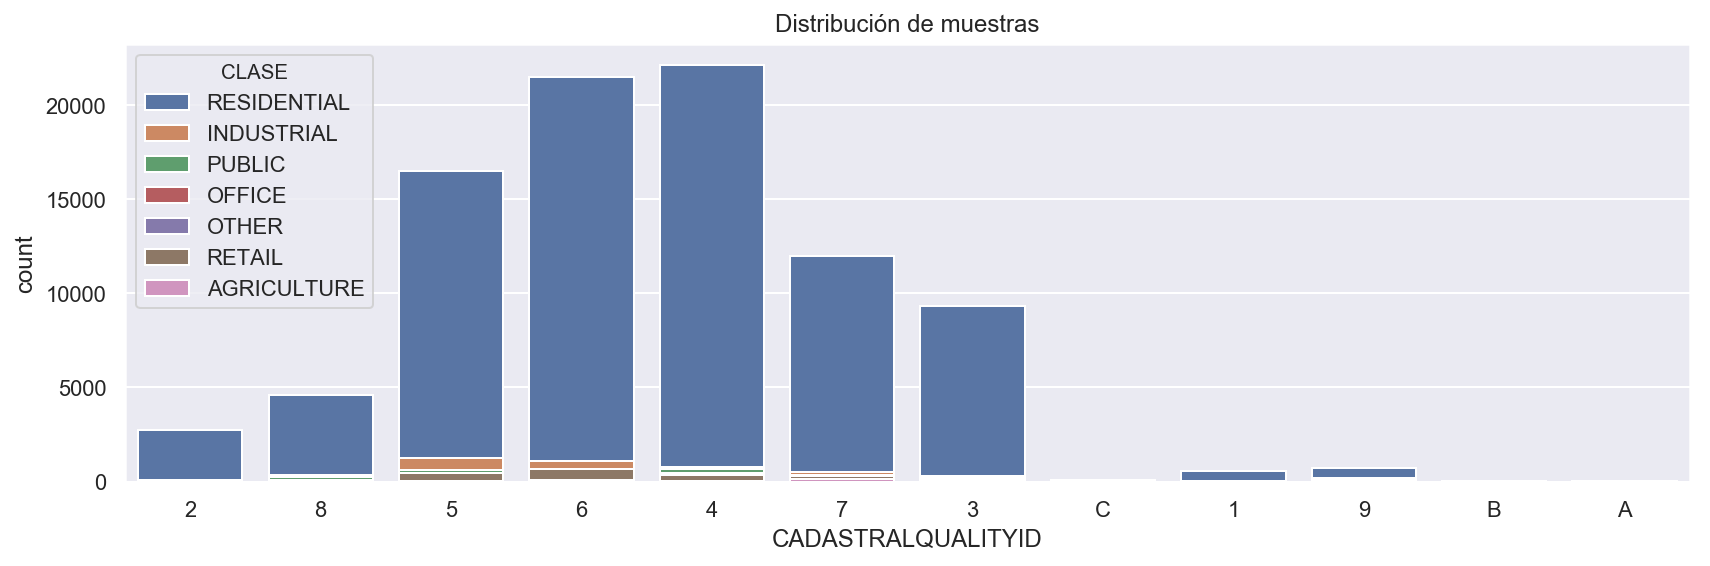

In [10]:
plt.figure(figsize=(12,4))
sns.countplot(x=df_modelar['CADASTRALQUALITYID'], data=df_modelar, hue="CLASE", dodge=False)
plt.title('Distribución de muestras');
plt.tight_layout()

Estos indicadores de calidad se pueden agrupar junto a su clasificación en la variable `CLASE`:

In [ ]:
# REVISAR
# df_modelar[df_modelar['CLASE']=='AGRICULTURE']['MAXBUILDINGFLOOR'].value_counts()

In [ ]:
cadatral_by_class = df_modelar.groupby('CADASTRALQUALITYID')['AREA'].mean()
cadatral_by_class

In [ ]:
cadatral_by_class = df_modelar.groupby('CLASE')['CADASTRALQUALITYID'].value_counts().unstack()
cadatral_by_class

In [ ]:
cadatral_by_class.sum()

Como podemos observar tras la agrupación, la calidad mayoritaria es la 5, que representaría aproximadamente la calidad media en el catastro. Por otro lado, la calidad más alta (11) presenta un número muy bajo de registros en comparación con el resto y la mayor parte de los mismos están clasificados como `RESIDENTIAL`. Si nos fijamos, también podemos observar que los registros clasificados como `AGRICULTURE` son los que peor calidad catrastral presental.

Además, los registros clasificados como `INDUSTRIAL` se situan entorno a una calidad de nivel 3 y 4.

<a id="section4"></a>
## <font color="#004D7F"> 4. Preprocesamiento del conjunto de datos</font>

Una vez realizado el análisis exploratorio de los datos y de las variables del _dataframe_ proporcionado, se deben de llevar a cabo las acciones de preprocesamiento necesarias.

Para ello haremos uso de la lista de funciones creada con anterioridad. En ella se han ido incluyendo las funciones necesarias y aunque en este caso unicamente contamos con una, como se ve a continuación, podemos añadir las que consideremos oportunas.

In [9]:
print("\nPasos de preprocesamiento: ")
for step, function in enumerate(list_preprocess_function):
    print("\t {:d}: {:s}".format(step, function.__name__))


Pasos de preprocesamiento: 
	 0: process_cadastral


La siguiente celda aplica cada una de las funciones de la lista al _dataframe_ que le introduzcamos como parámetro y devolverá el _dataframe_ modificado al realizar el preprocesamiento.

In [10]:
def preprocess_data(df, list_preprocess_function):
    for func in list_preprocess_function:
        func(df)
    return df

In [11]:
preprocess_data(df_modelar, list_preprocess_function)

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,...,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,
35984B9C3E7CD9A1,2207357872,165920300,0.000000e+00,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,...,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,7.0,RESIDENTIAL
F9D04BF6D037F8FB,2189757160,165463267,5.879611e-05,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,...,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,1.0,RESIDENTIAL
B89D5711AFF8C423,2240147335,165690752,0.000000e+00,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,...,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,4.0,RESIDENTIAL
1C3478AC1522E7E4,2227146459,165934099,0.000000e+00,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,...,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,7.0,RESIDENTIAL
4D12AA5009064345,2212350459,165681791,0.000000e+00,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,...,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,3.0,RESIDENTIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5FD596EB22DB167,2225843339,165482267,2.183254e-11,427.999246,604.004626,742.996454,866.005859,990.999512,1124.001465,1268.997705,...,7697.199141,118.691883,0.431234,0.058275,0.062346,1.069859,1970,5.0,3.0,RESIDENTIAL
A51D42F2EAB0E15E,2196745557,165159412,1.108565e-06,544.002496,690.999658,812.997748,933.008777,1055.998779,1187.997485,1340.002747,...,5657.631409,62.673700,0.469740,0.090090,0.083195,0.923461,1994,1.0,5.0,RESIDENTIAL
9B75473FE6396523,2261090490,165673813,0.000000e+00,572.003784,765.000366,924.996460,1097.998169,1329.000732,1609.997925,1974.998596,...,14891.610338,303.685474,0.938707,0.035331,0.087489,2.476290,1945,1.0,0.0,INDUSTRIAL


Una vez aplicadas cada una de las funciones anteriores, es importarte eliminar o añadir a las dos listas que manejabamos de vairables categórigas y numéricas las columnas que realmente pertenecen a ese tipo. Por ello, como la variable `CADASTRALQUALITYID` se ha tratado al final como una numérica, debemos de incluirla y eliminarla de las listas correspondientes.

In [12]:
dis_df_columns.remove('CADASTRALQUALITYID')
number_df_columns.append('CADASTRALQUALITYID')

Por último, a nivel informativo, se muestra en la siguiente celda las distintas columnas que se incluyen en cada una de las listas en función del tipo de variable que representan tras realizar el preprocesamiento de correspondiente y sabiendo que se ha eliminado la variable objetivo CLASE de la lista de variables categóricas.

In [13]:
print('Variables categóricas: ', dis_df_columns, end='\n\n')
print('Variables numéricas: ', number_df_columns)

Variables categóricas:  []

Variables numéricas:  ['X', 'Y', 'Q_R_4_0_0', 'Q_R_4_0_1', 'Q_R_4_0_2', 'Q_R_4_0_3', 'Q_R_4_0_4', 'Q_R_4_0_5', 'Q_R_4_0_6', 'Q_R_4_0_7', 'Q_R_4_0_8', 'Q_R_4_0_9', 'Q_R_4_1_0', 'Q_G_3_0_0', 'Q_G_3_0_1', 'Q_G_3_0_2', 'Q_G_3_0_3', 'Q_G_3_0_4', 'Q_G_3_0_5', 'Q_G_3_0_6', 'Q_G_3_0_7', 'Q_G_3_0_8', 'Q_G_3_0_9', 'Q_G_3_1_0', 'Q_B_2_0_0', 'Q_B_2_0_1', 'Q_B_2_0_2', 'Q_B_2_0_3', 'Q_B_2_0_4', 'Q_B_2_0_5', 'Q_B_2_0_6', 'Q_B_2_0_7', 'Q_B_2_0_8', 'Q_B_2_0_9', 'Q_B_2_1_0', 'Q_NIR_8_0_0', 'Q_NIR_8_0_1', 'Q_NIR_8_0_2', 'Q_NIR_8_0_3', 'Q_NIR_8_0_4', 'Q_NIR_8_0_5', 'Q_NIR_8_0_6', 'Q_NIR_8_0_7', 'Q_NIR_8_0_8', 'Q_NIR_8_0_9', 'Q_NIR_8_1_0', 'AREA', 'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4', 'CONTRUCTIONYEAR', 'MAXBUILDINGFLOOR', 'CADASTRALQUALITYID']


<a id="section41"></a>
### <font color="#004D7F">4.1 Creación de un Pipeline para la transformación </font>

Los _Pipelines_ son una herramienta extremadamente simple pero que nos permite ahorrar y gestionar flujos de trabajo en este tipo de problemas. Los _Pipelines_ están diseñados para aplicar una serie de transformaciones de datos seguidas por la aplicación de un estrimador.

Surgen por la necesidad de tratar de manera separada los datos, es decir, las variables categóricas se deben de tratar de distinta forma a las variables numéricas pero, posteriormente se deben de unir (mediante el uso del objeto ColumnTransformer)

En primer lugar, en la siguiente celda se crea un objeto de tipo _Pipeline_ que permite definir el proceso de transformación de las variables numéricas. Este objeto consiste en lo siguiente:
* Imputación de los valores perdidos mediante SimpleImputer, el cual tiene como estrategia _constant_ para completar con un valor establecido por nosotros mismos, que es el -1, que indicaría la peor calidad del catastro. 
* Normalización a media cero y desviación uno mediante el uso de StandardScaler.

In [14]:
#Transformación que se le va a aplicar a las columnas numéricas
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
                             ('scaler', StandardScaler())])

De igual formar que se ha realizado para las variables numéricas, también se debe de realizar para las variables categóricas. En este caso, el objeto _Pipeline_ creado consta de lo siguiente:
* Imputación de los valores perdidos mediante SimpleImputer reemplazando los valores perdidos por una etiqueta, de forma similar al caso anterior.
* Transformación de las variables categóricas a etiquetas binarias mediante un objeto OneHotEncoder

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Importante. Esto es solo una propuesta de trabajo y de desarrollo. En nuestro caso no contamos con variables categóricas a tratar, por lo que no es necesario la realización de este _Pipeline_ pero se adjunta a nivel informativo o por si en algun caso se añade alguna variable de este tipo.
</div>

In [15]:
#Transformación que se le aplicaría a las columnas categóricas, en el caso de que existan
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                           ('onehot', OneHotEncoder(handle_unknown='ignore'))])

Po último, una vez se tienen las dos secuencias de transformaciones anteriores, se deben de unir y aplicar a las características correspondientes. Para ello se hace uso de un objeto incluido recientemente en la librería de _scikit-learn_ llamado `ColumnTransformer`, que permite tratar por separado estas columnas.

En nuestro caso, este objeto se ha creado unicamente con el _Pipeline_ de las variables numéricas porque no tenemos variables categóricas a tratar.

In [16]:
#Transformador que se aplica a cada una de las columnas en función a lo declarado previamente
df_modelar_trans = ColumnTransformer(transformers=[('num', num_transformer, number_df_columns)])

<a id="section5"></a>
## <font color="#004D7F"> 5. Construcción de modelos </font>

El principal problema que tenemos a la hora de construir los modelos es el del gran desbalanceo de las clases que hemos visto en el apartado [3. Análisis exploratorio de los datos](#section3), donde tenemos la clase `RESIDENTIAL` como clase predominante con respecto al resto.

Para solventar este problema, vamos a utilizar la estrategia de **apilamiento de modelos**, es decir, utilizar un primer modelo que nos discrimine entre las clases `RESIDENTIAL` y `NO RESIDENTIAL`, la cual estará constituida por todos los registros cuya clase sea distinta a residencial. Lo que conseguimos con esto es hacer filtro de los datos y una vez obtengamos los registros cuya predicción sea `NO RESIDENTIAL` entonces los pasaremos a un segundo modelo, el cual estará entrenado con todas las clases, pero más balanceadas, manteniendo las distribuciones originales.

Dado que el primer modelo va seguir estando desbalanceado, puesto que disponemos de 90173 registros cuya clase es residencial y 23230 cuya clase es distinta a residencial, vamos a utilizar una técnica de **Oversampling** con la que vamos a generar registros sintéticos similares a los que tenemos en el conjunto de datos inicial mediante el algoritmo `SMOTE` (*Synthetic Minority Over-sampling Technique*) cuyo funcionamiento queda reflejado en el siguiente artículo: https://arxiv.org/pdf/1106.1813.pdf.

Con ello vamos a generar un modelo binario lo más balanceado posible, igualando los registros residenciales y los no residenciales, como se muestra a continuación:

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Los ejemplos aquí mostrados son representativos, pero los datos **no** son los reales debido a que no se ha realizado todavía el proceso.
</div>

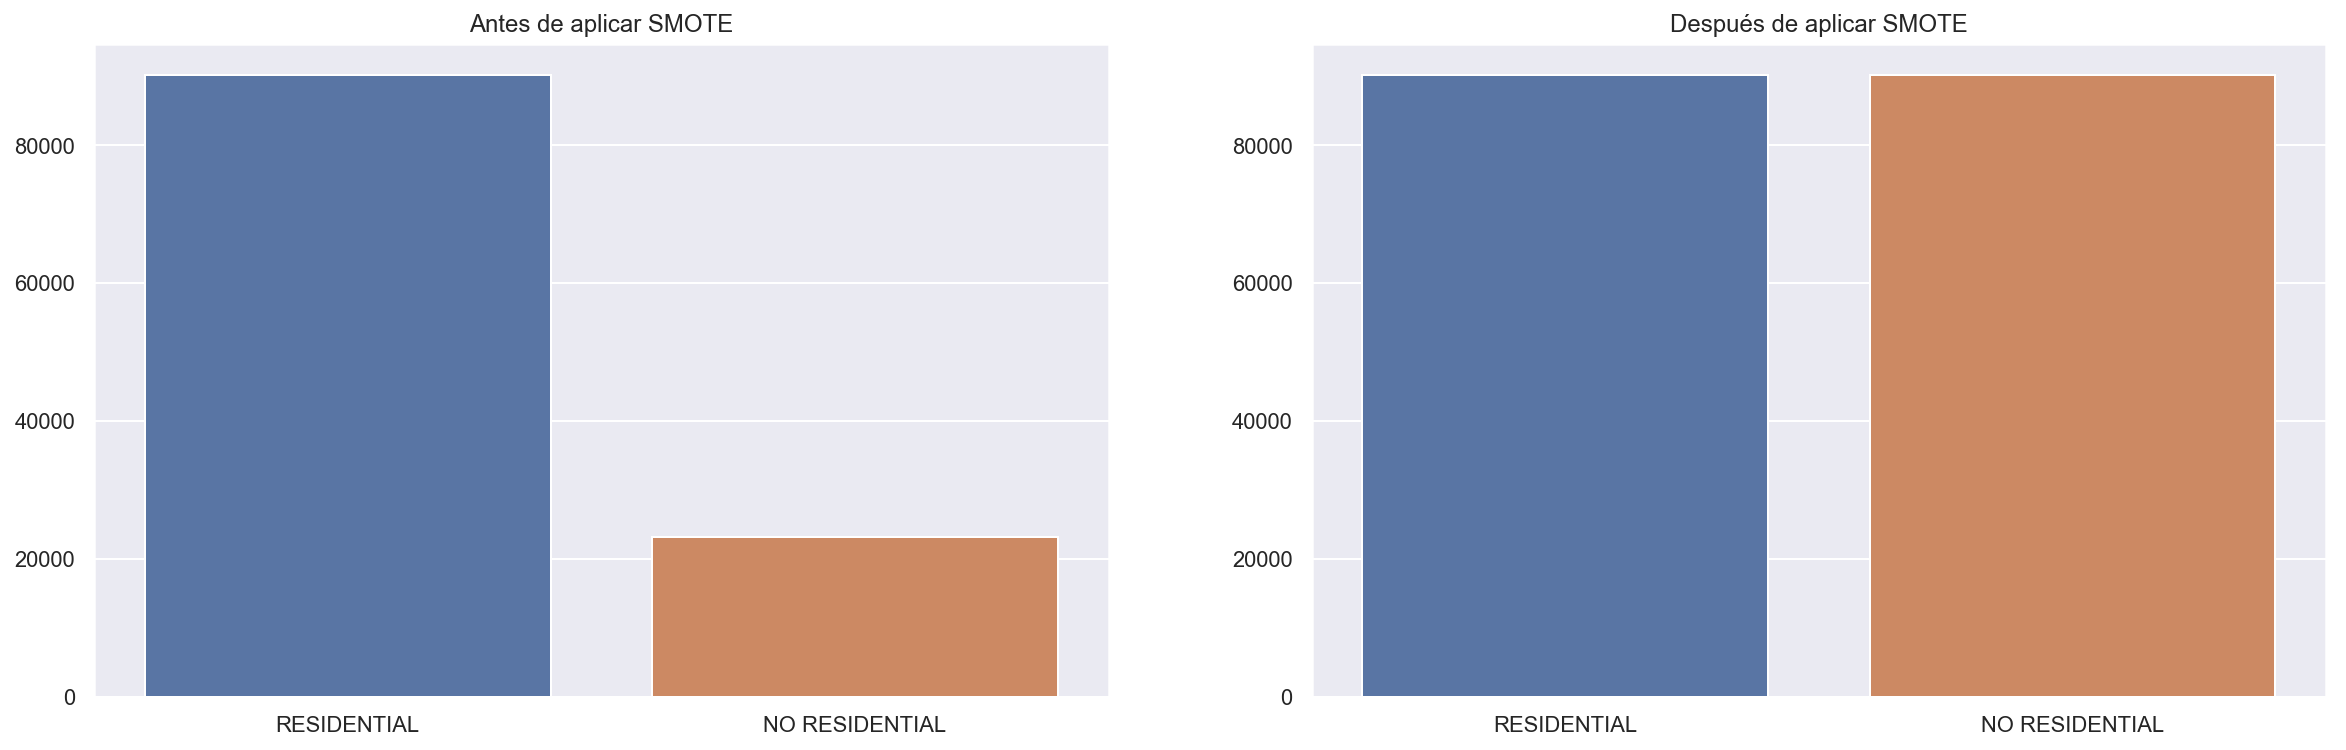

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.barplot(x=['RESIDENTIAL', 'NO RESIDENTIAL'], y=[90173, 23230], ax=ax1)
sns.barplot(x=['RESIDENTIAL', 'NO RESIDENTIAL'], y=[90173, 90173], ax=ax2)
ax1.set_title('Antes de aplicar SMOTE')
ax2.set_title('Después de aplicar SMOTE')
plt.show()

Sobre el nuevo conjunto de datos balanceado, entrenaremos una serie de modelos realizando una búsqueda exhaustiva de hiperparametros para conseguir obtener el mejor modelo con respecto a unas métricas establecidas.

Una vez obtengamos nuestro modelo binario, será hora de generar el segundo modelo, el modelo multietiqueta. Este modelo contemplará todas las clases presentes en el problema, con la condición de que ahora la clase mayoritaria no será la residencial, puesto que ha sido previamente clasificada por el modelo binario. Como consecuencia de ello, este segundo modelo será necesario entrenarlo con una distribución acorde al nuevo escenario de datos, el cual se puede observar a continuación:

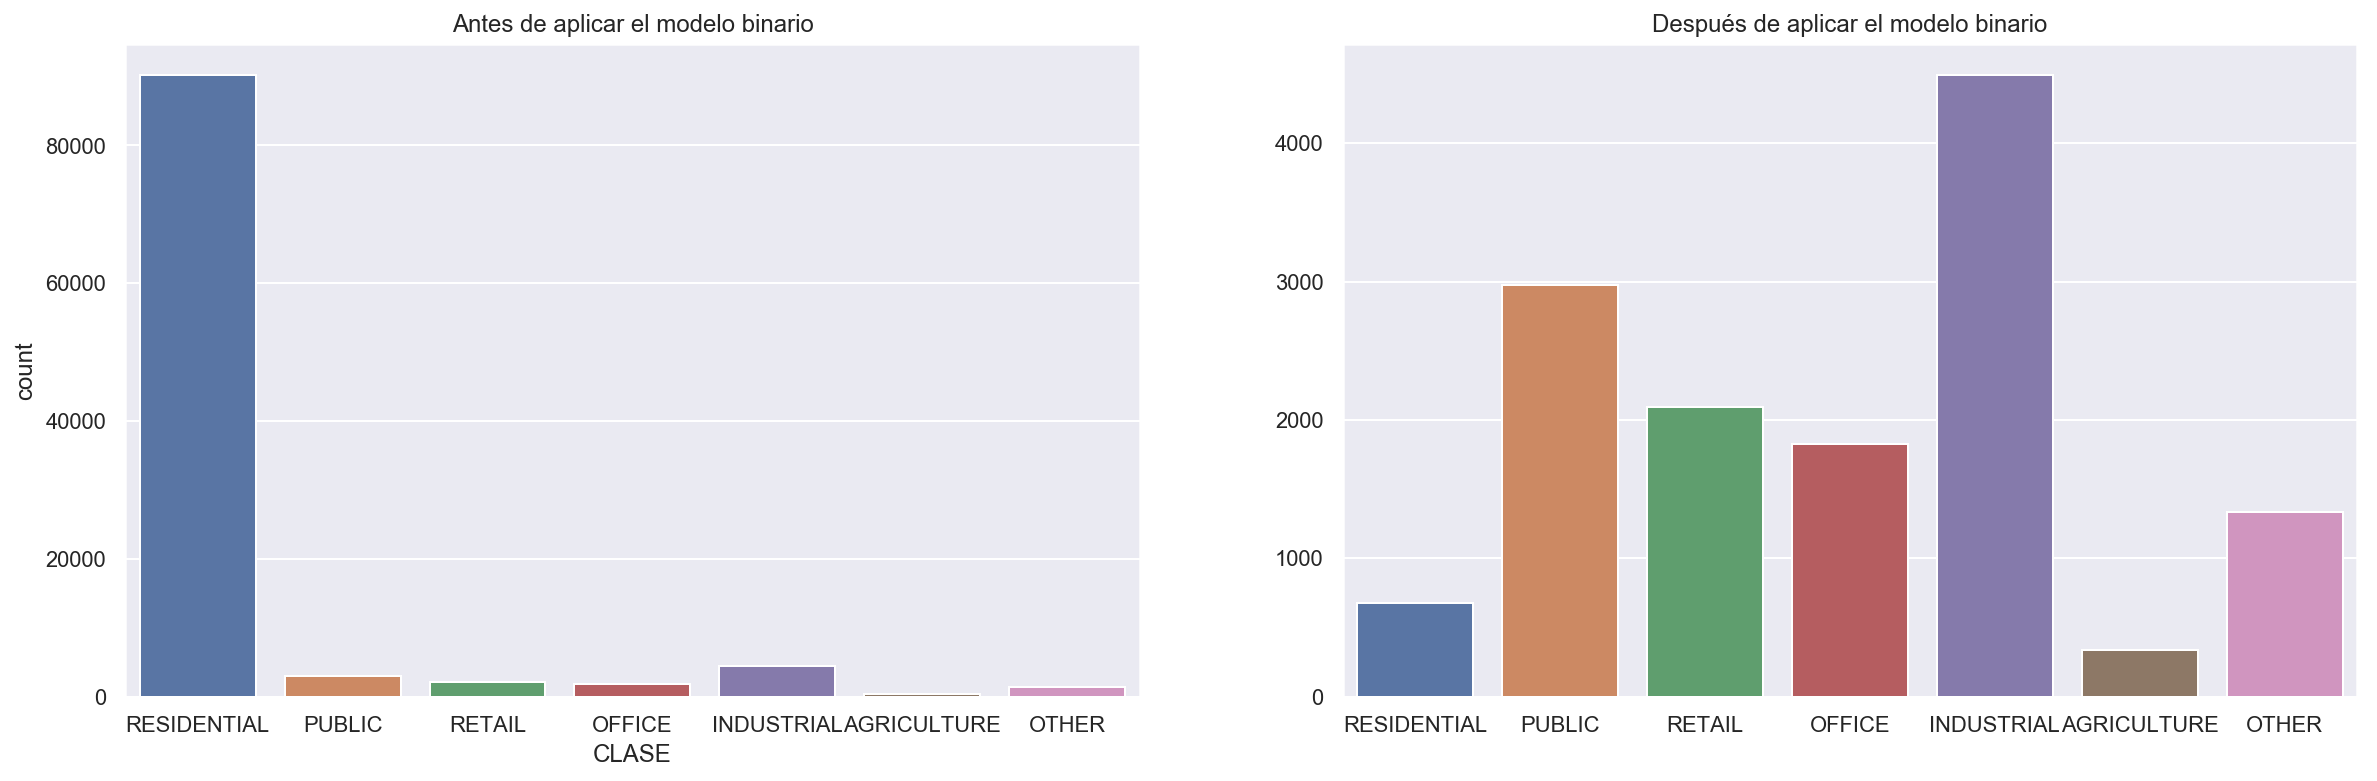

In [174]:
datos_filtrados = df_modelar[df_modelar['CLASE']!='RESIDENTIAL']['CLASE'].value_counts() \
        .append(pd.Series(index=['RESIDENTIAL'], data=[678]))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
sns.countplot(df_modelar['CLASE'], order=list_class_order, ax=ax1)
sns.barplot(x=datos_filtrados.index, y=datos_filtrados.values, order=list_class_order, ax=ax2)
ax1.set_title('Antes de aplicar el modelo binario')
ax2.set_title('Después de aplicar el modelo binario')
plt.show()

Como podemos observar, tras aplicar el modelo binario, hemos conseguido balancear manteniendo las distribuciones originales del resto de clases que no son la residencial. Puede resultar curioso, el porqué hay registros de la clase `RESIDENTIAL` una vez aplicado el modelo binario, y esto es debido a que el modelo posiblemente presente fallos a la hora de clasificar, por lo que habrá casos residenciales que los clasifique como no residenciales. Con esta propuesta, la clase residencial también podrá ser clasificada, tendrá por así decirlo una "*segunda oportunidad*", ya que lo normal es que el modelo binario previamente generado presente un % de error en su predicción y con esta estrategia, corregimos en la medida de lo posible ese error producido.

La estrategia a aplicar en este momento es parecida al primero modelo, utilizar el algoritmo SMOTE sobre el conjunto de datos para así conseguir balancear totalmente todas las clases, una vez las tengamos balanceadas entrenar nuestro segundo modelo, el cual será en este caso multietiqueta. Por lo tanto, el conjunto de entrenamiento en nuestro segundo modelo será similar al mostrado a continuación:

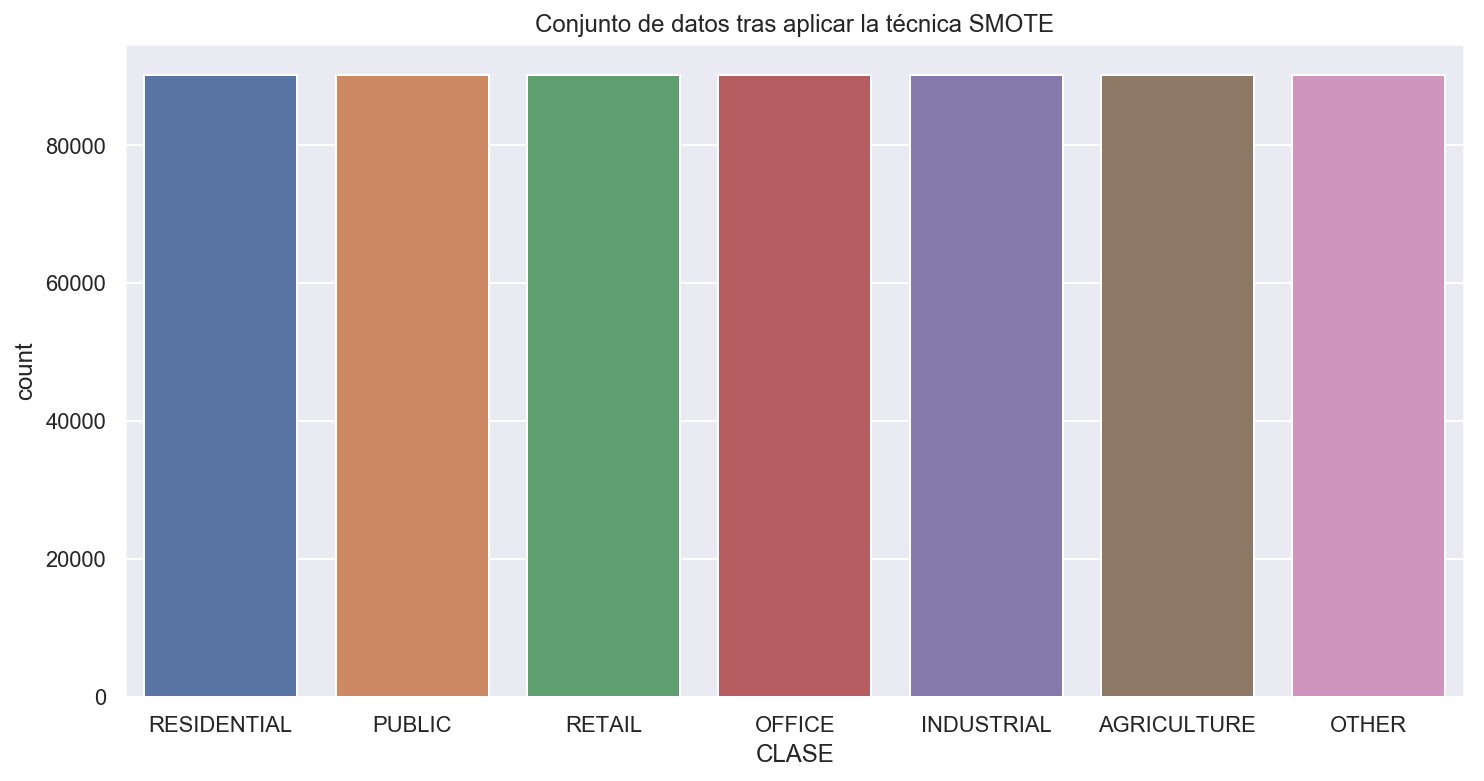

In [184]:
datos_filtrados = df_modelar[df_modelar['CLASE']=='RESIDENTIAL']['CLASE'].value_counts()
for c in df_modelar['CLASE'].unique():
    if c != 'RESIDENTIAL':
        datos_filtrados = datos_filtrados.append(pd.Series(index=[c], data=[datos_filtrados[0]]))
plt.figure(figsize=(12,6))
sns.barplot(x=datos_filtrados.index, y=datos_filtrados.values, order=list_class_order)
plt.title('Conjunto de datos tras aplicar la técnica SMOTE')
plt.xlabel('CLASE')
plt.ylabel('count')
plt.show()

<a id="section51"></a>
### <font color="#004D7F">5.1 Construcción de modelo binario </font>


Lo primero que debemos hacer es generar una nueva variable en función a la variable `CLASE` que nos permita identificar si el registro hace referencia a la clase `RESIDENTIAL` o `NO RESIDENTIAL`. Para ello, vamos a hacer uso de la siguiente función:

In [17]:
def assing_subclass(df):
    df['SUBCLASE'] = (df['CLASE'] == 'RESIDENTIAL').astype(int)
assing_subclass(df_modelar)

Una vez generada la nueva variable, es hora de utilizar el algoritmo `SMOTE`. El cual nos va a permitir realizar un aumento de registros de manera sintética con respecto aquellos de la clase minoritaria, es decir, la no residencial.

In [18]:
#Separamos en conjunto de datos, de la variable a predecir, que en este caso es la nueva que hemos generado en el paso previo
X = df_modelar.drop(columns=df_modelar.columns[-2:]).copy() #Importante, debemos eliminar también la variable clase para no afectar en el entrenamiento
y = df_modelar['SUBCLASE'].copy() #La clase a predecir va a ser la que hemos generado y la que nos va a permitir discretizar

#Realizamos un SMOTE para la clase minoritaria para así balancear el conjunto de datos
sm = SMOTE(random_state=10, sampling_strategy='not majority')

Seguidamente, el nuevo conjunto de datos generado debemos dividirlo en un conjunto de train y de test para poder entrenar nuestros modelos.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

Con respecto a que modelos de clasificación debemos entrenar, hemos optado por los siguientes algoritmos de clasificación. A pesar de que hay una gran variedad, estos son los que nosotros conocemos con mayor precisión y nos sentimos más cómodos de utilizar:
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">LogisticRegression</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html">SGDClassifier</a>
- <a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html">XGBOOST</a>

Para el entrenamiento de cada uno de los diferentes algoritmos de clasificación se ha utilizado una de las funciones incluidas en el paquete de *scikit-learn*, llamada `GridSearchCV`. Mediante esta función nos es posible evaluar y seleccionar los mejores parámetros para el algoritmo de clasificación en cuestión.

Para ello hace uso de la _validación cruzada_ con el fin de evitar la aparación de sobreajuste y dando como resultado modelos más estables y con mejores resultados. La _validación cruzada_ consiste en dividir el conjunto de entramiento en grupos de igual tamaño y entrenar el modelo una vez por cada uno de los diferentes grupos creados. Así pues, se utilizan todos los grupos excepto el de la iteración para entrenar el algoritmo y el restante para la validación del mismo.

En la siguiente imagen que se adjunta y que ha sido extraida de <a href="https://www.analyticslane.com/2018/07/02/gridsearchcv/">Analytic Lane</a> se puede ver un ejemplo muy sencillo de este método:

<img src="data/validacion_cruzada.jpeg">

Además, los parámetros que hemos incluido en cada uno de los _GridSearchCV_ son los siguientes:

* **estimator**: algoritmo/modelo que se desea evaluar. En nuestro caso este parámetro lo completamos introduciendo el _Pipeline_ creado.
* **parameters**: diccionario en el cual se indican los distintos parámetros que se han de evaluar.
* **cv**: número total de conjuntos en los cuales se va a dividir el conjunto de datos para la _validación cruzada_.
* **n_jobs**: para que el procesamiento utilice todos los núcleos disponibles en el ordenador o máquina que se ejecute.
* **scoring**: métrica utilizada para evaluar el modelo.
* **refit**: este parámetro hace que, una vez concluida y obtenida la mejor configuración de los parámetros, se entrene el modelo con todos los datos.
* **verbose**: este parámetro nos permite obtener información sobre el estado de la ejecución del gridsearch.

In [ ]:
# xgb_model = xgb.XGBClassifier(random_state=10)
# 
# parameters = {
#         'clas__min_child_weight': [1, 5, 10],
#         'clas__gamma': [0.5, 1, 1.5, 2, 5],
#         'clas__subsample': [0.6, 0.8, 1.0],
#         'clas__colsample_bytree': [0.6, 0.8, 1.0],
#         'clas__n_estimators': [100, 200, 500],
#         'clas__max_depth': [2, 5, 10, 20, 30]
# }
# 
# pipe_xgboost = Pipeline(steps=[('prep', df_minsait_trans), ('clas', xgb_model)])
# 
# GS = GridSearchCV(pipe_xgboost, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
# GS.fit(X_train, y_train)
#     
# print("Mejor score: ", GS.best_score_)
# print("Mejore configuración de parámetros: ", GS.best_params_)
# 
# pipe_xgboost = GS.best_estimator_

<div class="alert alert-block alert-danger">
    
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
Este proceso conlleva un importante uso de los recursos del ordenador y del tiempo de entrenamiento de cada modelo con sus hiperparametros, no ejecutar salvo que sea estrictamente necesario.
</div>

In [29]:
seed = 10

models = [
    'SGD',
    'Logistic regression',
    'Decision tree',
    'Random forest',
    'Xgboost'
]

params = { 
        'SGD': 
            {'clf': SGDClassifier(random_state=seed),
            'params': [{'clas__max_iter': [50, 100, 1000], 'clas__tol': [1e-3, 1e-4]}]},
        'Logistic regression': 
            {'clf': LogisticRegression(random_state=seed),
            'params': [{'clas__tol': [0.001,0.0001,0.00001], 'clas__C': np.linspace(0.0001,1.0,5)}]},
        'Decision tree': 
            {'clf': DecisionTreeClassifier(random_state=seed),
            'params': [{'clas__max_depth': [3, 5, 7, 10]}]},
        'Random forest': 
            {'clf': RandomForestClassifier(random_state=seed),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [3, 5, 7, 10, 20]}]},
        'Xgboost':
            {'clf': xgb.XGBClassifier(random_state=seed),
            'params': [{'clas__n_estimators': [100, 200], 'clas__max_depth': [3, 5, 7, 10, 20]}]}
}

results = {}

def train_models(models):
    for m in models:
        start_time = time.time()
        print(f"Vamos a entrenar el modelo: {m}")
        model = params[m]['clf']
        parameters = params[m]['params']
        pipe = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', model)])
        GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
        GS.fit(X_train, y_train)
        print(f"Mejor score para el modelo {m}: ", GS.best_score_)
        print("Mejore configuración de parámetros: ", GS.best_params_)

        pipe = GS.best_estimator_
        end_time = (time.time() - start_time)
        
        results[m] = {'time': end_time, 'score': GS.best_score_, 'params': GS.best_params_, 'estimator': pipe}
        
train_models(models)
#print(results)

Vamos a entrenar el modelo: SGD
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.7s finished


Mejor score para el modelo SGD:  0.8471927646440914
Mejore configuración de parámetros:  {'clas__max_iter': 1000, 'clas__tol': 0.0001}
Vamos a entrenar el modelo: Logistic regression
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.1min finished


Mejor score para el modelo Logistic regression:  0.8328421017999897
Mejore configuración de parámetros:  {'clas__C': 0.250075, 'clas__tol': 0.001}
Vamos a entrenar el modelo: Decision tree
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:   11.2s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   15.0s finished


Mejor score para el modelo Decision tree:  0.8840454688550301
Mejore configuración de parámetros:  {'clas__max_depth': 10}
Vamos a entrenar el modelo: Random forest
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


Mejor score para el modelo Random forest:  0.916441817411387
Mejore configuración de parámetros:  {'clas__max_depth': 20, 'clas__n_estimators': 200}
Vamos a entrenar el modelo: Xgboost
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 14.1min finished


Mejor score para el modelo Xgboost:  0.9304742685133286
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 200}
{'SGD': {'time': 26.602778911590576, 'score': 0.8471927646440914, 'params': {'clas__max_iter': 1000, 'clas__tol': 0.0001}, 'estimator': Pipeline(memory=None,
         steps=[('prep',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_va

#### <font color="#004D7F">Comparativa diferentes algoritmos de clasificación </font>

En este apartado se explica con detenimiento los resultados obtenidos en cada uno de los diferentes algoritmos de clasificación entrenados para este primer modelo binario.

In [102]:
times = []
accuracies = []
for m in models:
    time = np.round(results[m]["time"]/60, 3)
    accuracy = np.round(results[m]["score"], 3)
    print(f'Para el modelo \033[1m{m}\033[0m el tiempo es: \033[1m{time}\033[0m minutos y el score obtenido es: \033[1m{accuracy}\033[0m')
    times.append(time)
    accuracies.append(accuracy)

Para el modelo SGD el tiempo es: 0.443 minutos y el score obtenido es: 0.847
Para el modelo Logistic regression el tiempo es: 1.179 minutos y el score obtenido es: 0.833
Para el modelo Decision tree el tiempo es: 0.318 minutos y el score obtenido es: 0.884
Para el modelo Random forest el tiempo es: 4.997 minutos y el score obtenido es: 0.916
Para el modelo Xgboost el tiempo es: 17.485 minutos y el score obtenido es: 0.93


Como era de esperar, el algoritmo de clasificación que más tiempo ha necesitado para su correcto entrenamiento mediante un _GridSearchCV_ ha sido el **Xgboost** empleando casi 18 minutos de tiempo debido a su complejidad y operaciones internas (las cuales se explican con más detalles en la <a hr="https://xgboost.readthedocs.io/en/latest/">página oficial</a>). 

El **Random Forest** al ser también un modelo complejo, requiere algo más de tiempo en comparación con el resto de algoritmos.

Estos dos algoritmos emplean tanto tiempo porque sus hiperparámetros abarcan un amplio número de configuraciones y hemos introducido un número de estimadores y de profundidad (la cual hemos limitado para que no sobreajuste nuestro modelo).

El **SGD** , **Logistic regression** y **Decision tree** son algoritmos de clasificación _sencillos_ que no necesitan una configuración extensa de sus hiperparámetros, no necesitan un gran tiempo de ejecución.

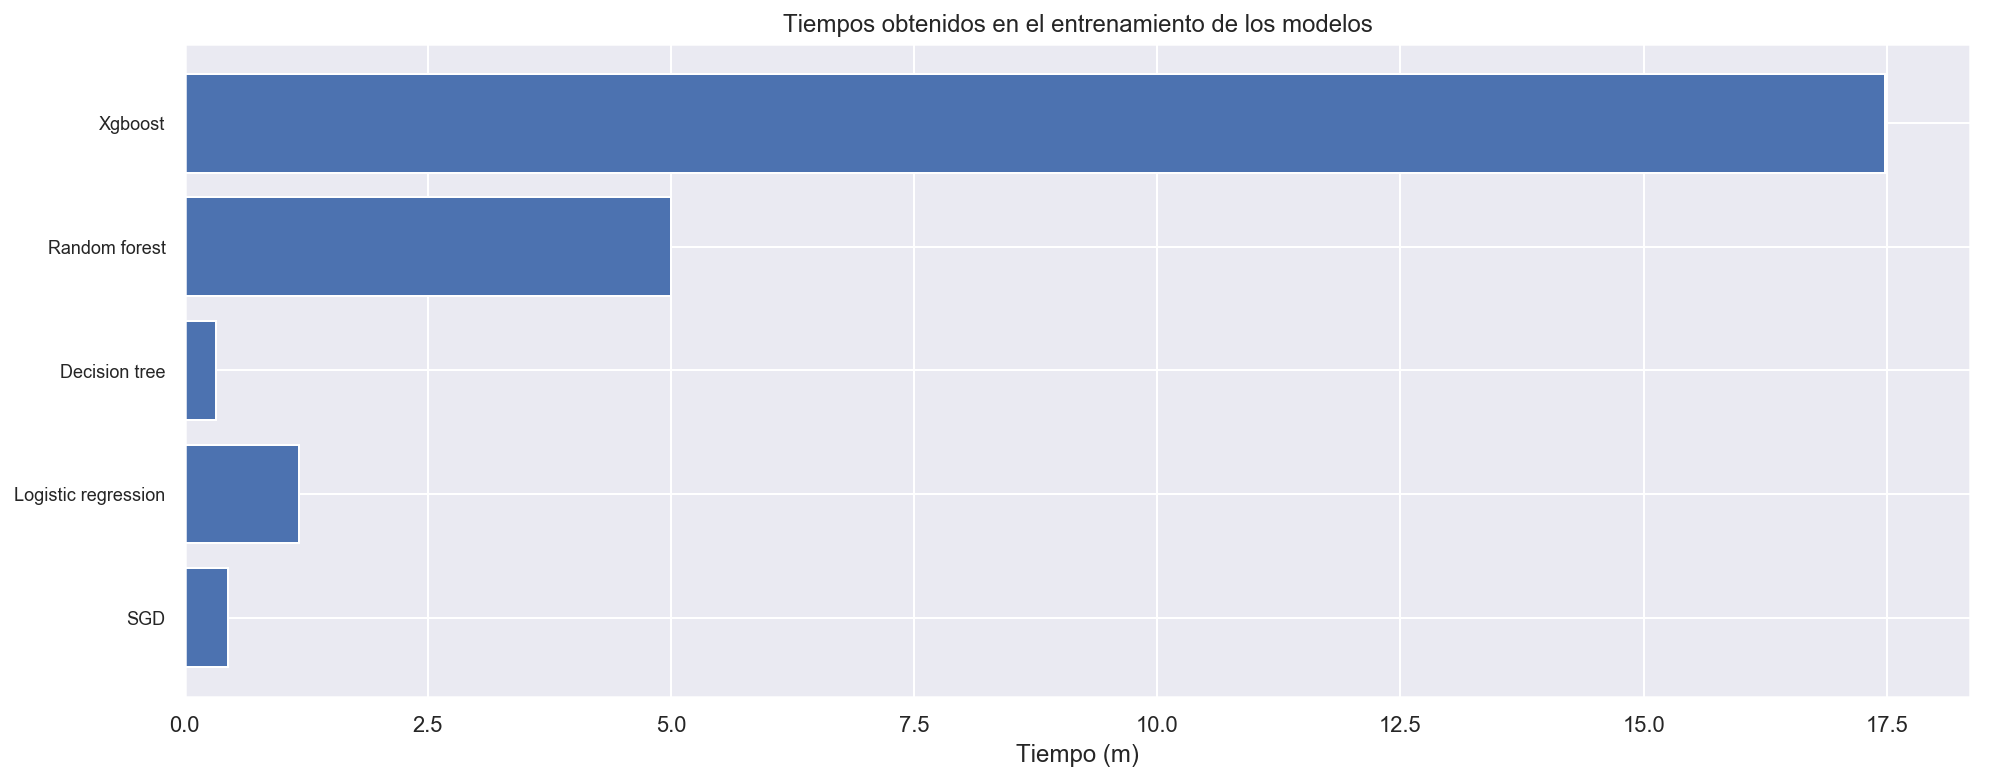

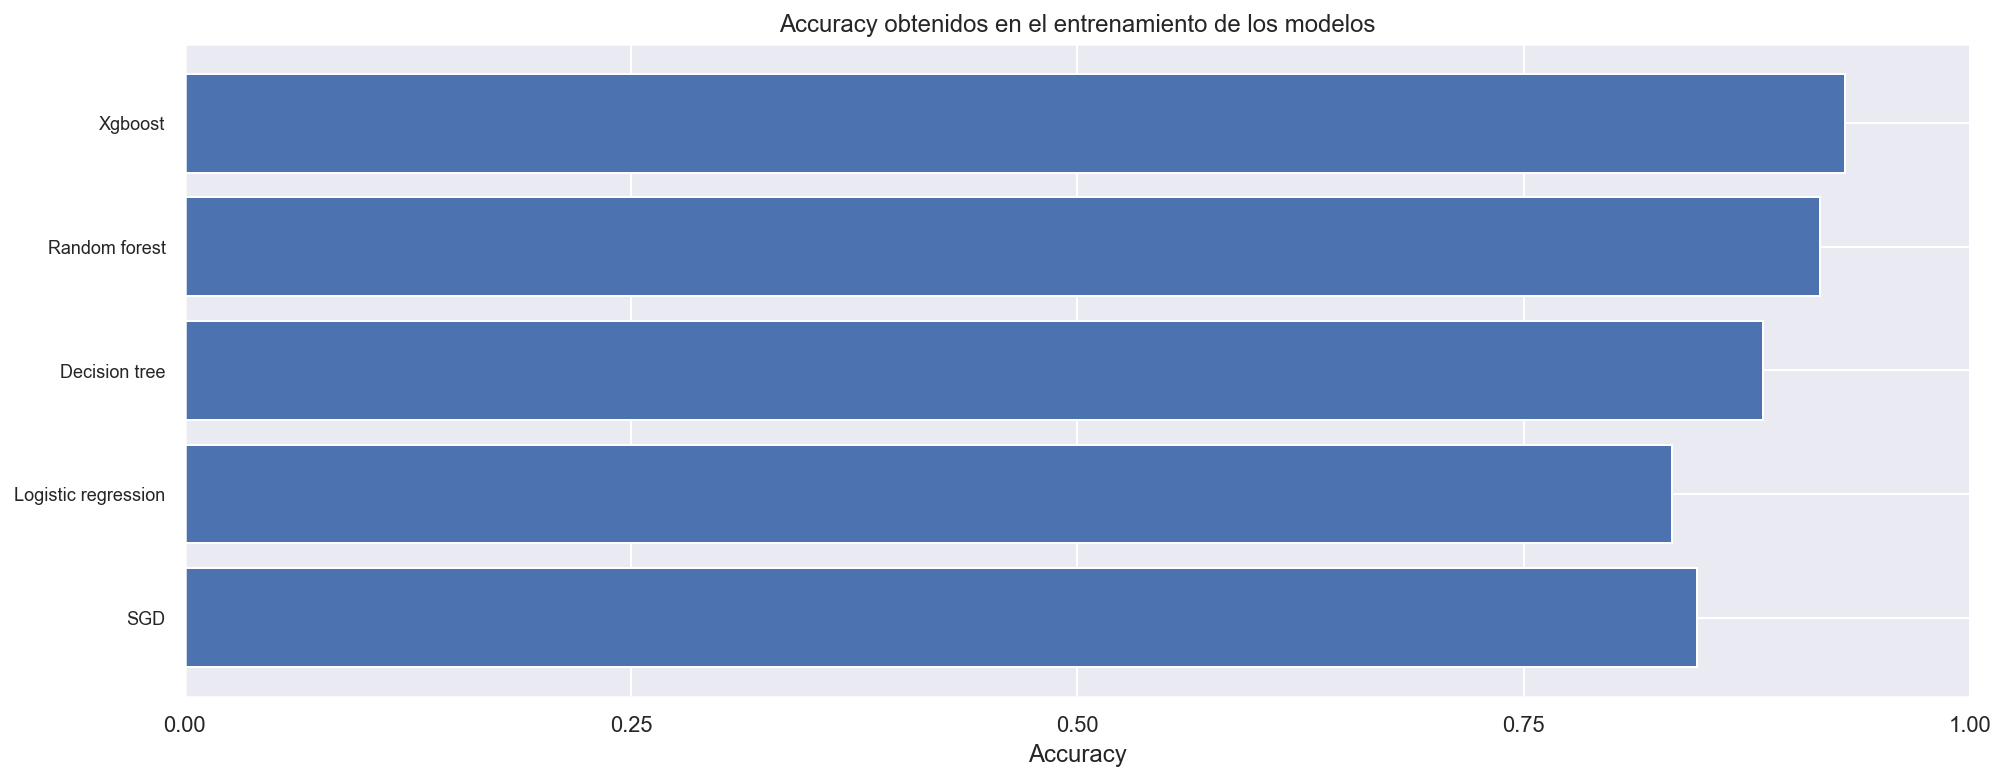

In [90]:
plt.figure(figsize=(16,6))
plt.title("Tiempos obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(times)), times, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xlabel('Tiempo (m)')
plt.show()

plt.figure(figsize=(16,6))
plt.title("Accuracy obtenidos en el entrenamiento de los modelos")
plt.barh(range(len(accuracies)), accuracies, align='center')
plt.yticks(range(len(models)), models, fontsize=9)
plt.xticks(np.linspace(0,1,5))
plt.xlabel('Accuracy')
plt.show()

En la primera gráfica que se muestra en la parte superior de esta celda se puede observar el tiempo empleado por cada uno de los distintos algoritmos de clasificación empleados para este problema, los cuales se han comentado con anterioridad.

En nuestro caso, como el objetivo del reto es intentar maximizar el _accuracy_ lo máximo posible solamente nos fijaremos en dos de los algorimos entrenados: el **Xgboost** y el **Random Forest** los cuales compararemos más en profunidad a continuación.

En la segunda gráfica se ha representado de forma gráfica el _accuracy_ obtenido con cada uno de los diferentes algoritmos y como era casi de esperar, el **Xgboost** es el que mayor _accuracy_ presenta, seguido del **Random Forest**. El resto de algoritmos no obtiene un mal resultado, pero debemos de tener en cuenta que a priori nos puede parecer un _accuracy_ lo suficientemente alto como para barajar la posibilidad de usar estos algoritmos, pero nuestro conjunto de datos está altamente desbalanceado y por ello se obtienen resultados tan elevados.

Es por ello por lo que se deben de consultar otro tipo de métricas adicionales, que se explicarán a continuación.

Es la siguiente tabla, se muestra a modo de resumen, toda la información obtenida de cada uno de los algoritmos. Se divide en:
* **Modelo:** algoritmo de clasificación utilizado.
* **Time(m):** tiempo (en minutos) empleado para su entrenamiento.
* **Accuracy:** resultado obtenido en la métrica empleada en cada uno de ellos.
* **AUC:** resultado del área bajo la curva obtenido para cada uno de los diferentes algoritmos.
* **Params** parámetros utilizados en el _GridSearchCV_ para el entrenamiento de los algoritmos de clasificación.

<table class="table table-hover">
    <thead>
        <tr> <th>Modelo</th> <th>Time (m)</th> <th>Accuracy</th> <th>AUC</th> <th>Params</th></tr> 
    </thead>
    <tbody>
        <tr> <td>SGD</td> <td>0.443</td> <td>0.847</td> <td>0.749</td> <td>max_iter: 1000, tol: 0.0001</td> </tr>
        <tr> <td>Logistic regression</td> <td>1.179</td> <td>0.833</td> <td>0.75</td> <td>C: 0.250075, tol: 0.001</td> </tr>
        <tr> <td>Decision tree</td> <td>0.318</td> <td>0.884</td> <td>0.8</td> <td>max_depth: 10</td> </tr>
        <tr> <td>Random forest</td> <td>4.997</td> <td>0.916</td> <td>0.824</td> <td>max_depth: 20, n_estimators: 200</td> </tr>
        <tr> <td>Xgboost</td> <td>17.485</td> <td>0.93</td> <td>0.807</td> <td>max_depth: 10, n_estimators: 200</td> </tr>
    </tbody>
</table>

El área bajo la curva es una columna que se ha introducido en esta tabla y que hace referencia a la probabilidad de que el modelo entrenado clasifique un ejemplo positivo totalmente aleatorio más alto que un ejemplo negativo también aleatorio. Esta explicación se puede representar de forma gráfica en la siguiente imagen, obtenida de <a href="https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es-419">aquí</a>.


<img src="data/AUCPredictionsRanked.svg">

#### <font color="#004D7F">Obtención de las predicciones para los modelos de interés</font>

Una vez se ha entrenado correctamente cada uno de los diferentes modelos, y partiendo de la base de que unicamente vamos a realizar la comprobación con el **Random Forest** y el **Xgboost** se deben de calcular las predicciones para cada uno de ellos, estudiarlas y seleccionar el modelo que mejor se ajuste a nuestras necesidades.

In [155]:
def analize_model(m, X_test, y_test, accuracy=True, prc=False, ranking=False):
    estimator = results[m]['estimator']
    y_pred = estimator.predict(X_test)
    if accuracy:
        show_results(y_test, y_pred)
    if prc:
        #plot_precision_recall_curve(estimator, X_test, y_test);
        plot_roc_curve(y_test, y_pred)
    if ranking:
        if (m in ['Decision tree', 'Random forest', 'Xgboost']):
            # Extrae las importancias
            importances = estimator['clas'].feature_importances_
            # Extrae los índices ordenados de menor a mayor
            ranking = np.argsort(importances)

            #Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
            plt.figure(figsize=(28,20))
            plt.title(f"Ranking de importancias de las variables con {m}")
            plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
            plt.yticks(range(df_modelar.shape[1]-2), X.columns[ranking], fontsize=9)
            plt.show()
    print('\n')

Primero vamos a analizar el modelo obtenido del `Random forest` vs `Xgboost`. Analizaremos las matrices de confusión obtenidos por cada uno de ellos, las gráficas de precision recall, y finalmente, las variables más importantes para cada uno de los modelos a la hora de clasificar.

Para comenzar, analizaremos una serie de métricas que son las siguientes:
* **Accuracy**: el accuracy se define como el porcentaje de casos acertados por el clasificador.
* **Precision**: la precisión se define como el porcentaje de clasificaciones correctas realizadas por el modelo entrenado, es decir, de todo lo que el moodelo clasifica positivo, cual es el ratio de acierto.
* **Recall**: el recall se define como el porcentaje de casos positivos detectados por el modelo, es decir, de todos los positivos reales (sean detectados o no), cual es el porcentaje de positivos acertados.
* **F1-score**: el f1-score se define como la media entre la precision y el recall. Simplemente es una métrica que permite la combinación de las anteriores, asumiento que ambas tienen la misma importancia.

Para el caso del **Random Forest** podemos observar que el _accuracy_ presenta muy buenos resultados teniendo en cuenta que se ha hecho un _oversample_ de los datos. Además, el resto de métricas presentan también muy buenos resultados aunque se aprecia una pequeña disminución en la _precision_ y por lo tanto en el _recall_ para el caso 0 (no residencial).

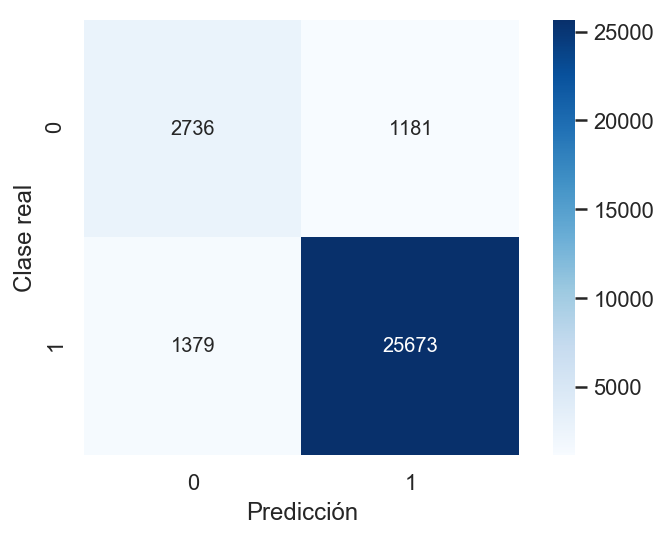

Accuracy: 0.917
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      3917
           1       0.96      0.95      0.95     27052

    accuracy                           0.92     30969
   macro avg       0.81      0.82      0.82     30969
weighted avg       0.92      0.92      0.92     30969





In [158]:
analize_model('Random forest', X_test, y_test, True, False, False)

En el caso del **Xgboost** nos encontramos también con un _accuracy_ bastante alto y también con unos buenos resultados en el resto de métricas. A diferencia del **Random Forest** en este modelo se observa un mejor resultado en el caso de la métrica _precision_ y por lo tanto también del _f1-score_. Es principalmente este motivo el que nos ha hecho decantarnos por este modelo.

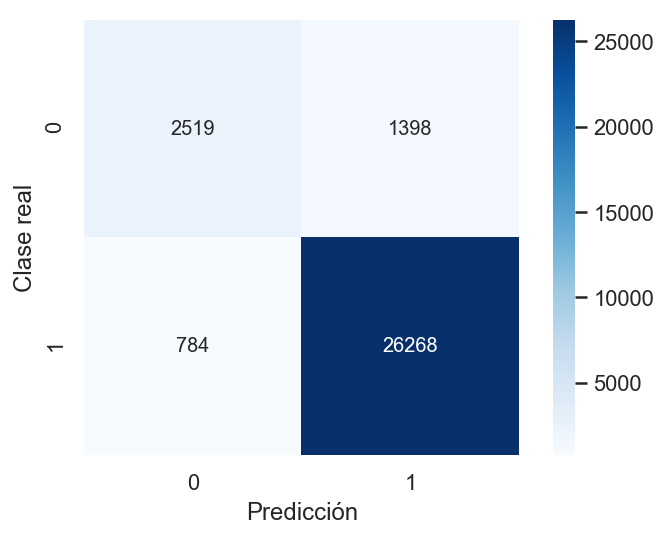

Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.76      0.64      0.70      3917
           1       0.95      0.97      0.96     27052

    accuracy                           0.93     30969
   macro avg       0.86      0.81      0.83     30969
weighted avg       0.93      0.93      0.93     30969





In [159]:
analize_model('Xgboost', X_test, y_test, True, False, False)

A continuación vamos a comparar el _Área bajo la curva_ de los dos modelos, para comprender realmente como de bueno es con respecto al resto. Esta curva representa la tasa de verdaderos positivos frente a la tasa de falsos positivos y el AUC se encarga de medir el área bidimensional por debajo de la curva.

El valor del AUC oscila entra 0 y 1. Por ejemplo, si tenemos un modelo con un AUC igual a 1, implica que el 100% de sus predicciones son correctas y por el contrario, si el AUC es de 0, significa que el 100% de sus predicciones son erróneas.

En el caso del **Random Forest** se presenta un AUC de 0.82, es decir, el 82% de sus predicciones son correctas. Este valor es realmente bueno, pero como hemos visto anteriormente, buscamos un equilibrio entre todas las métricas posibles.

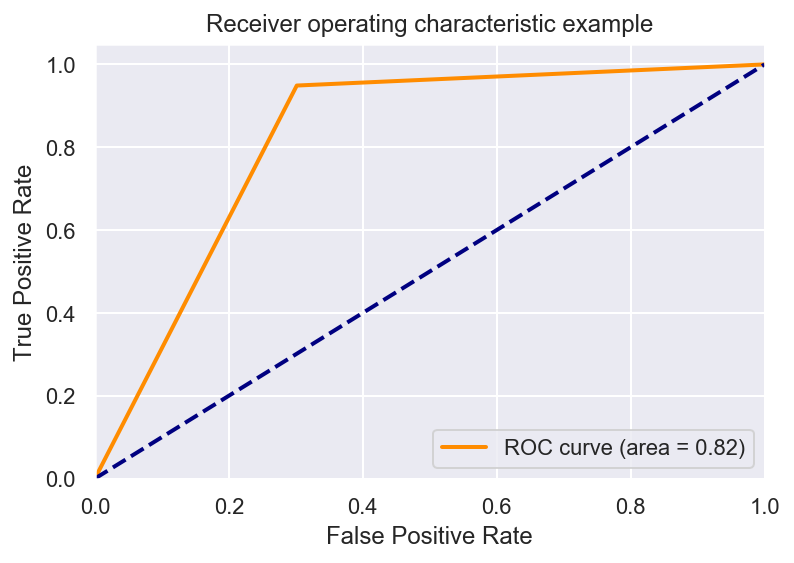

In [160]:
analize_model('Random forest', X_test, y_test, False, True, False)

Para el caso del **Xgboost** tenemos un AUC de 0.81, un valor también bastante bueno. Por lo tanto, ambos modelos presentan un AUC similar, ya que no existe casi diferencia entre ellos, pero son las métricas comendas anteriormente las que nos han hecho decantarnos por el **Xgboost**.

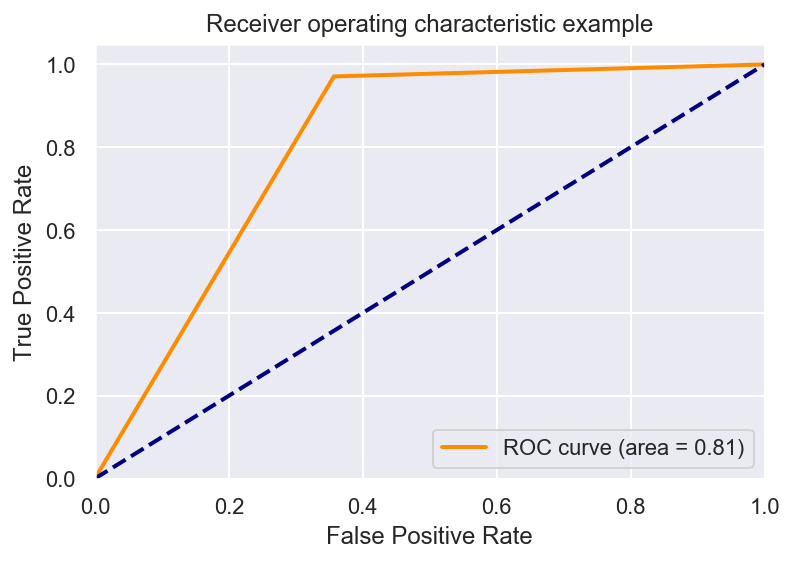

In [161]:
analize_model('Xgboost', X_test, y_test, False, True, False)

Por último, se realiza el estudio del ranking de la importancia que presenta cada una de las diferentes variables del conjunto de datos para el modelo entrenado.

En el caso del **Random Forest** podemos observar que de todas las variables, las que mayor importancia tienen para el entrenamiento del modelo son las geométricas, las de posición y las clasificadas anteriormente como _otras_ que son `MAXBUILDINGFLOO` y `CADASTRALQUALITYID`. Por lo cual, las variables relacionadas con los colores son las que menor importancia presencian.

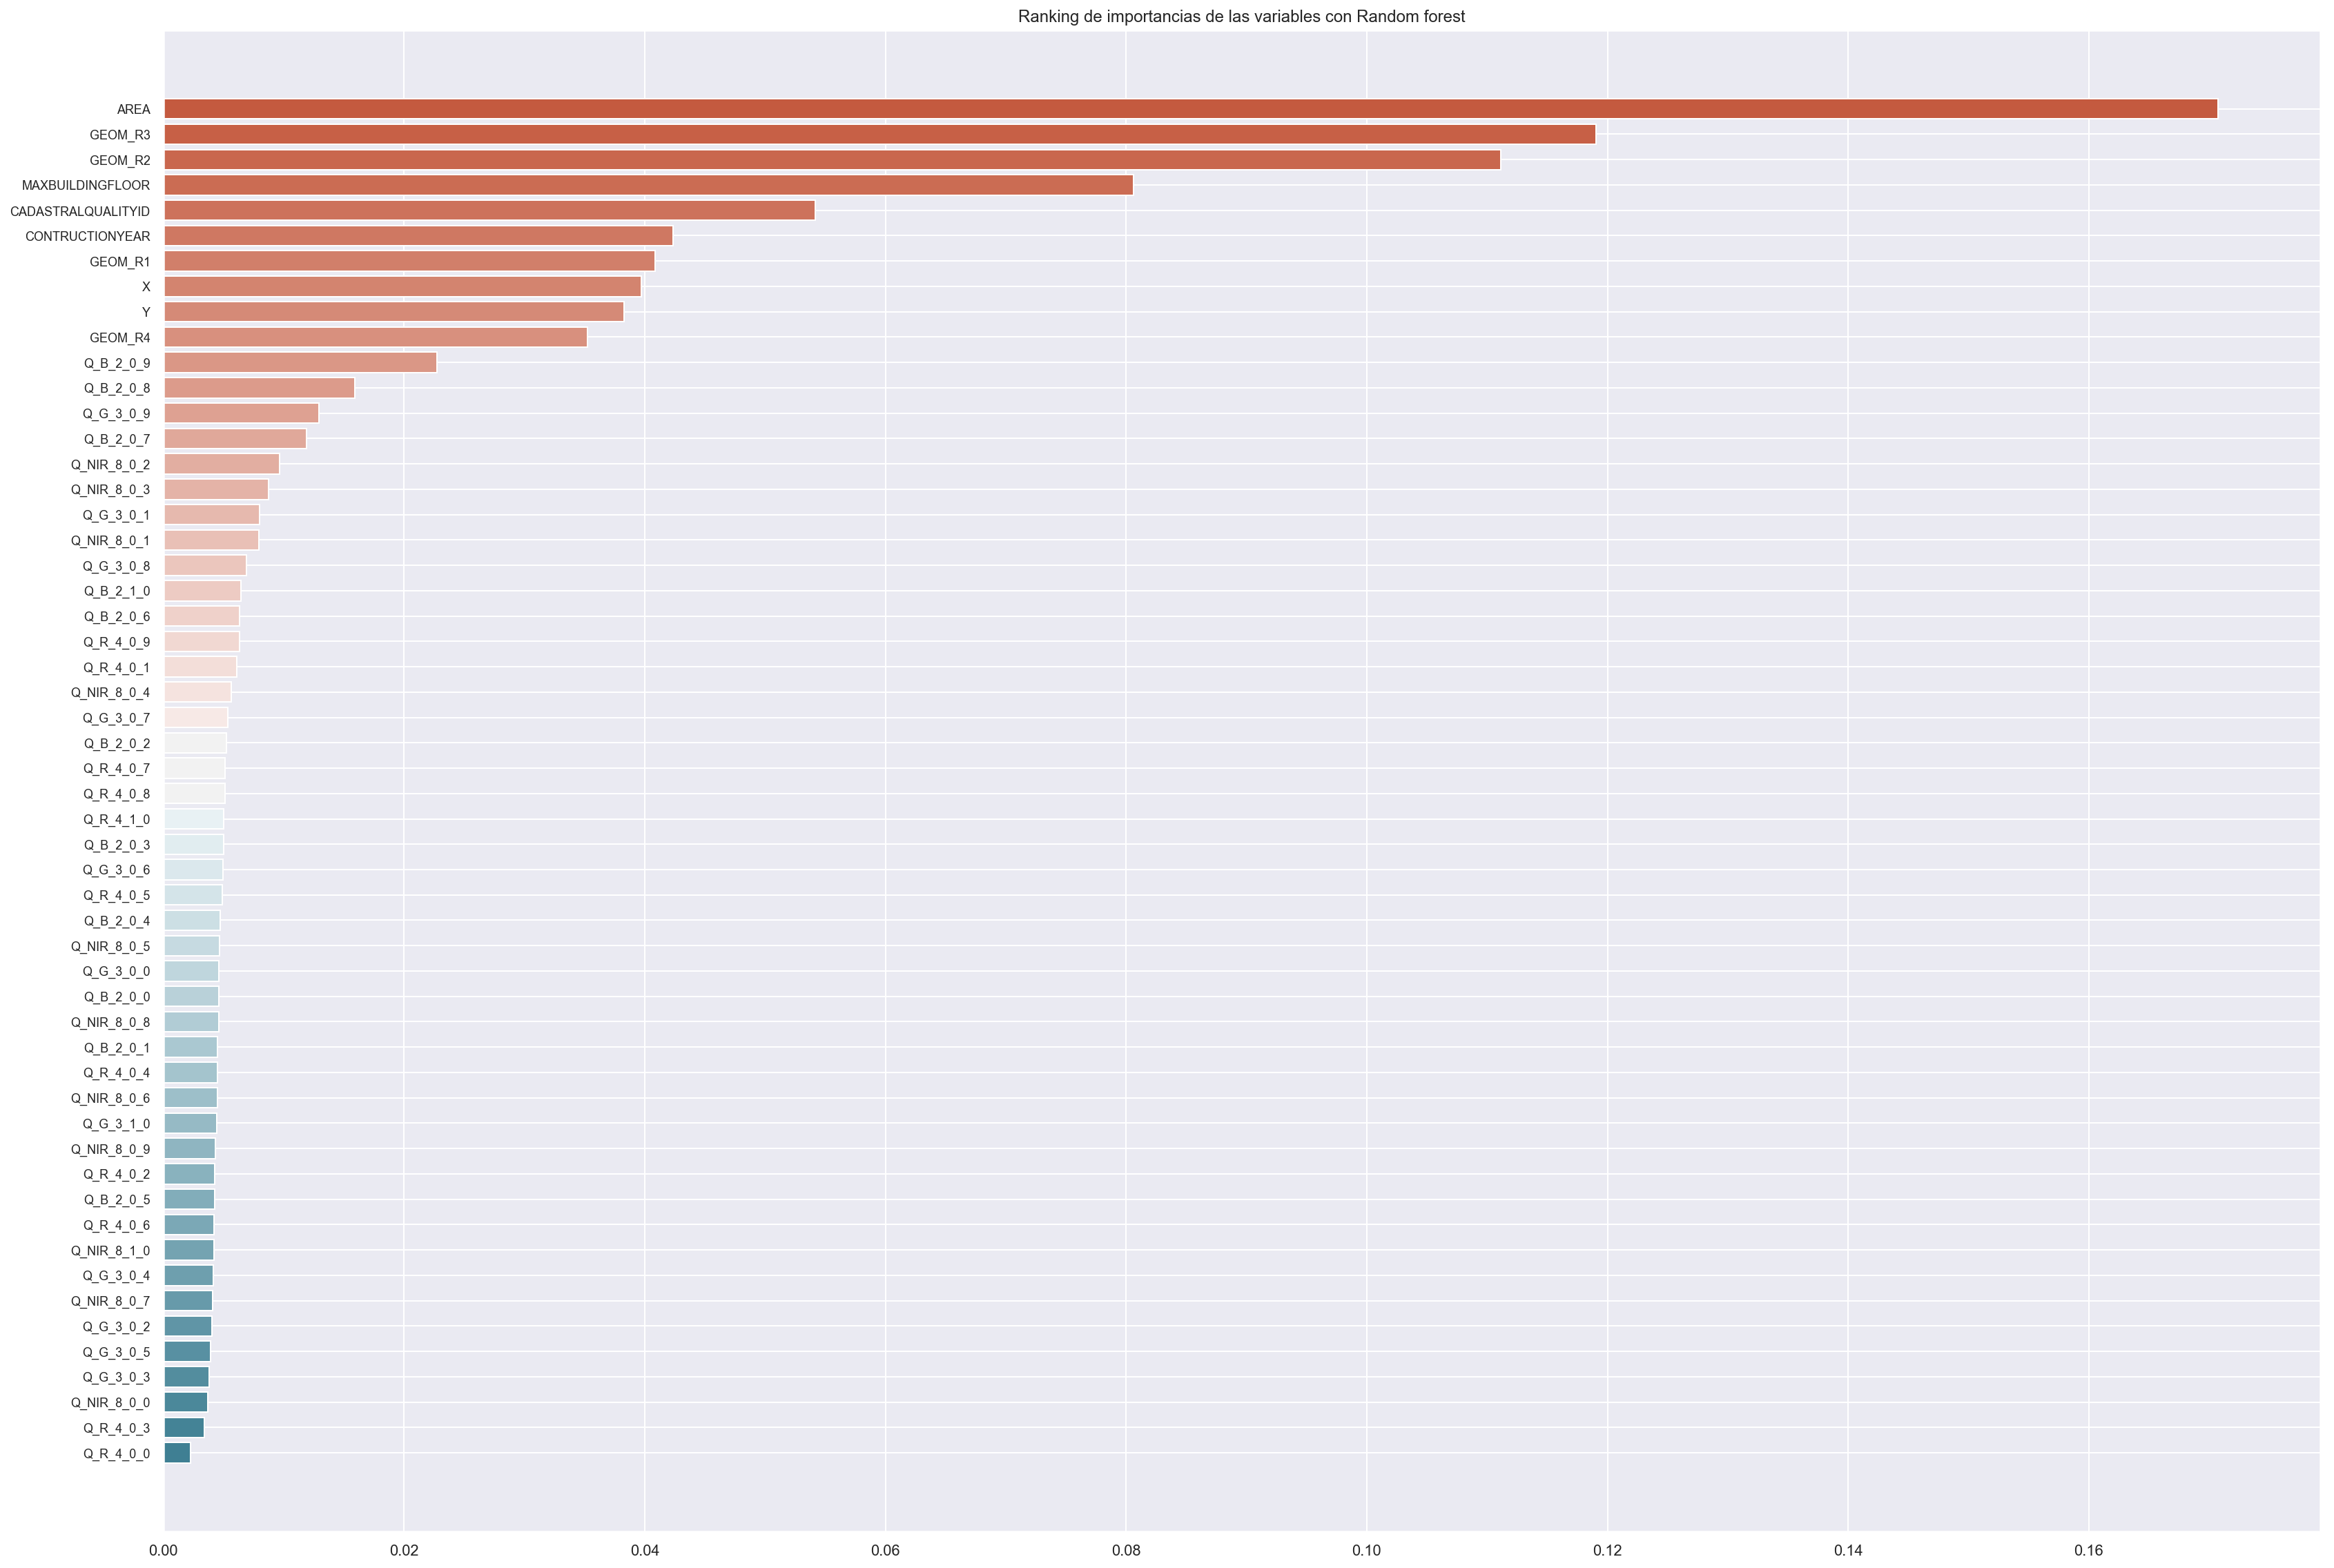

In [162]:
analize_model('Random forest', X_test, y_test, False, False, True)

A diferencia del modelo anterior, en el **Xgboost** las variables con mayor importancia son totalmente distintas, como se puede observar en la gráfica.

Anteriormente, las variables geométricas y de posición eran las que mayor importancia tenían, y aquí sin embargo se situan en las últimas posiciones de la gráfica. Por el contrario, las variables de los colores toman una mayor importancia en este modelo, mientras que variables como `MAXBUILDINGFLOO` y `CADASTRALQUALITYID` siguen aportando bastante información a los modelos entrenados.

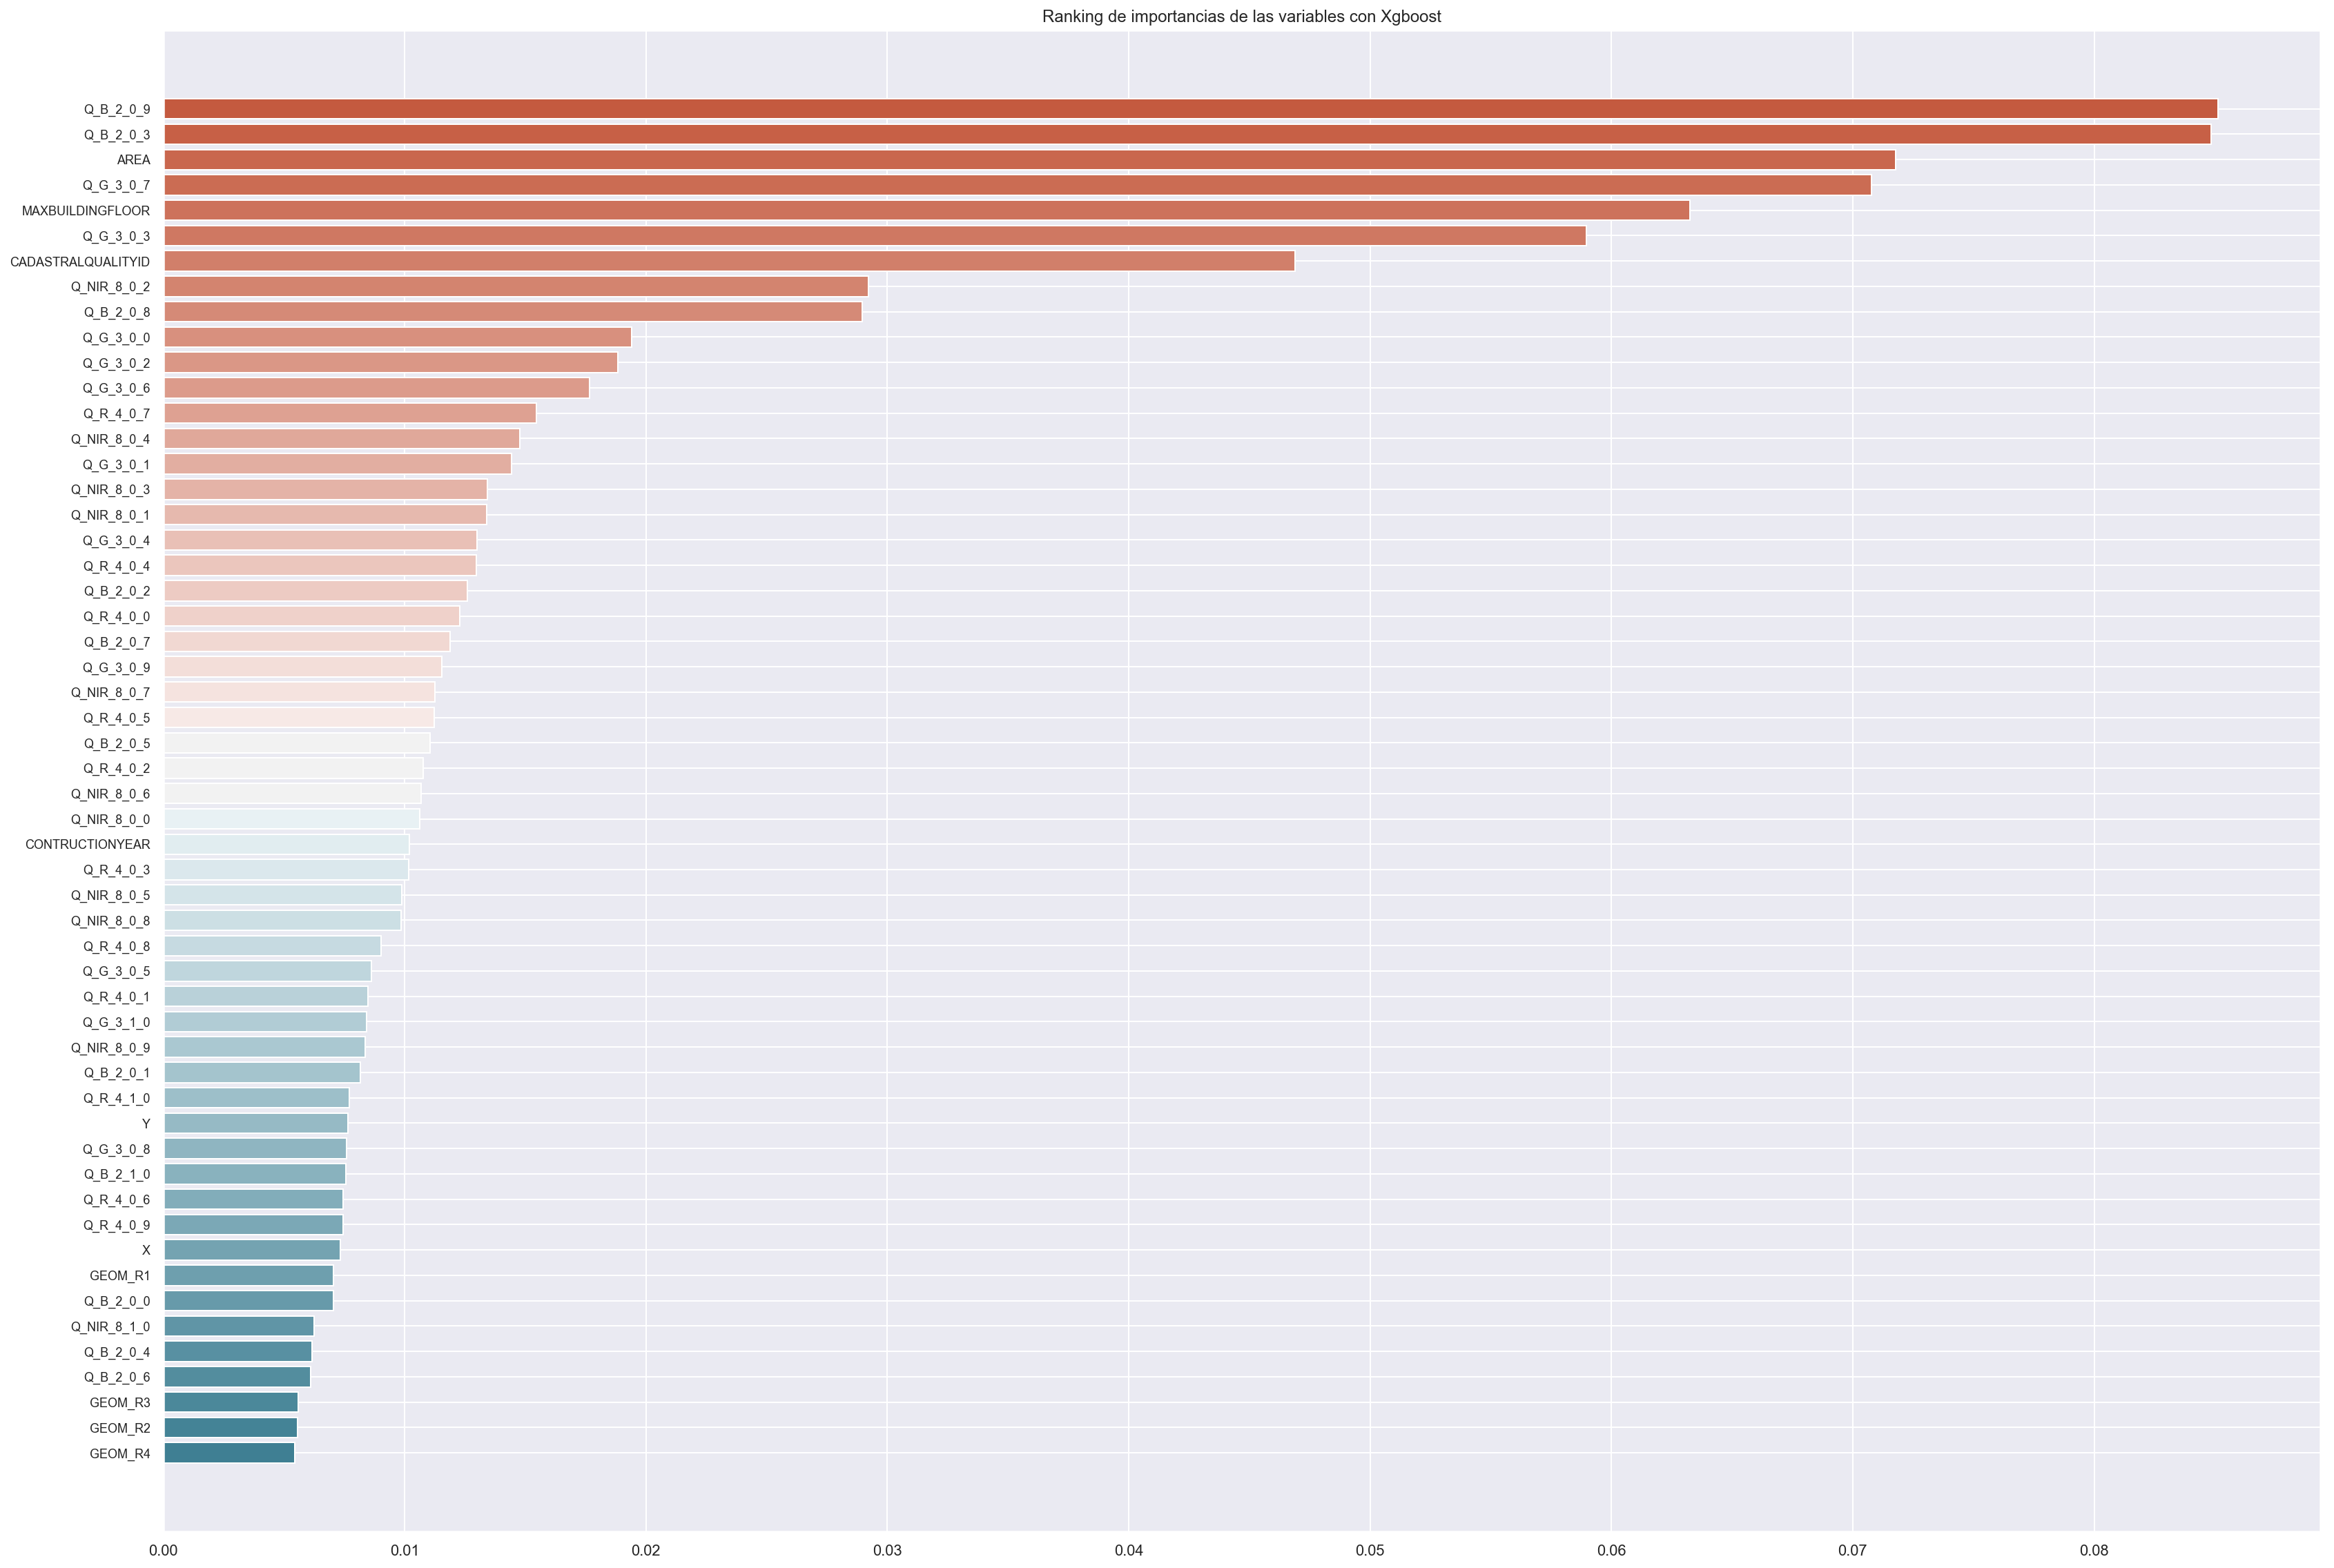

In [163]:
analize_model('Xgboost', X_test, y_test, False, False, True)

Gracias a estas dos gráficas podemos observar que todas las variables son importantes y en mayor parte el resultado obtenido depende más bien del algoritmo de clasificación elegido. Para unos son importantes unas variables y para otro son otras totalmente distintas.

En esta importancia también entra en juego el tipo de variable y el tipo de algoritmo de clasificación, pero es curioso de ver como dos algoritmos no muy dispares presentan una importancia de sus variables totalmente distinta.

---

De aqui para abajo alomejor hay que eliminarlo

# Para entrenar individualmente un modelo

In [36]:
from imblearn.pipeline import Pipeline
xgb_model = xgb.XGBClassifier(random_state=10)

#Parametros obtenidos del anterior gridsearch
parameters = {
        'clas__n_estimators': [100],
        'clas__max_depth': [10]
}

pipe_xgboost = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', xgb_model)])

GS = GridSearchCV(pipe_xgboost, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train, y_train)
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

pipe_xgboost = GS.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Mejor score:  0.926737815076131
Mejore configuración de parámetros:  {'clas__max_depth': 10, 'clas__n_estimators': 100}


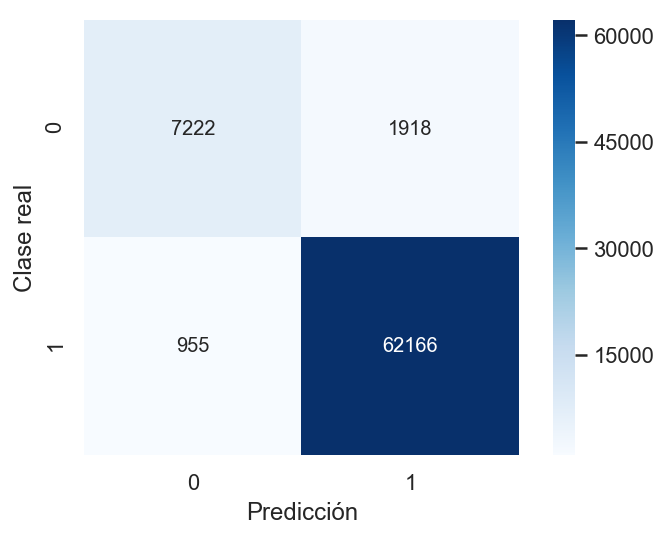

Resultados
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      9140
           1       0.97      0.98      0.98     63121

    accuracy                           0.96     72261
   macro avg       0.93      0.89      0.91     72261
weighted avg       0.96      0.96      0.96     72261



In [37]:
y_pred_train = pipe_xgboost.predict(X_train)
show_results(y_train, y_pred_train)
print(classification_report(y_train, y_pred_train))

<a id="section52"></a>
### <font color="#004D7F">5.2 Construcción de modelo multietiqueta </font>

Dado que los mejores modelos que hemos obtenido han sido el `Random Forest` y el `Xgboost` y que hemos utilizado para el modelo binario finalmente el `Xgboost`, para el siguiente modelo vamos a utilizar el `Random Forest`.

Vamos a utilizar la misma estrategia de SMOTE para balancear todas las clases y sobre ellas, entonces entrenar el modelo multietiqueta.

In [186]:
X = df_modelar.drop(columns=df_modelar.columns[-2:]).copy()
y = df_modelar['CLASE'].copy() #En este caso utilizamos la clase a predecir en vez de la subclase generada para el primer modelo

sm = SMOTE(random_state=10, sampling_strategy='not majority')

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [197]:
model = RandomForestClassifier(random_state=10)

parameters = {}
parameters['clas__max_depth'] = [20] #Quitamos None para que no sobreajuste al conjunto de train y que no pueda hacer la profundidad que el modelo desee. 
                                               # Lo forzamos a ponerle profundidad, como máximo 20, aunque se podría establecer mayor profundidad pero no queremos que sobreajute a los datos del train.
parameters['clas__n_estimators'] = [200]
parameters['clas__class_weight'] = ['balanced']

pipe = Pipeline(steps=[('prep', df_modelar_trans), ('smt', sm), ('clas', model)])
GS = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
GS.fit(X_train, y_train)
print(f"Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)

pipe = GS.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


KeyboardInterrupt: 

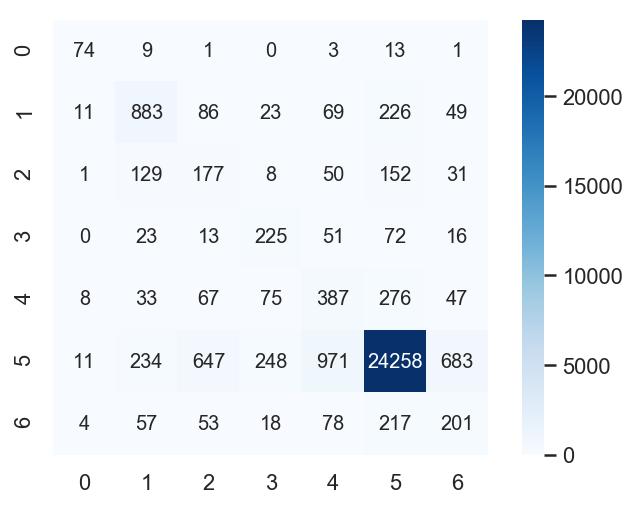

              precision    recall  f1-score   support

 AGRICULTURE       0.68      0.73      0.70       101
  INDUSTRIAL       0.65      0.66      0.65      1347
      OFFICE       0.17      0.32      0.22       548
       OTHER       0.38      0.56      0.45       400
      PUBLIC       0.24      0.43      0.31       893
 RESIDENTIAL       0.96      0.90      0.93     27052
      RETAIL       0.20      0.32      0.24       628

    accuracy                           0.85     30969
   macro avg       0.47      0.56      0.50     30969
weighted avg       0.89      0.85      0.87     30969



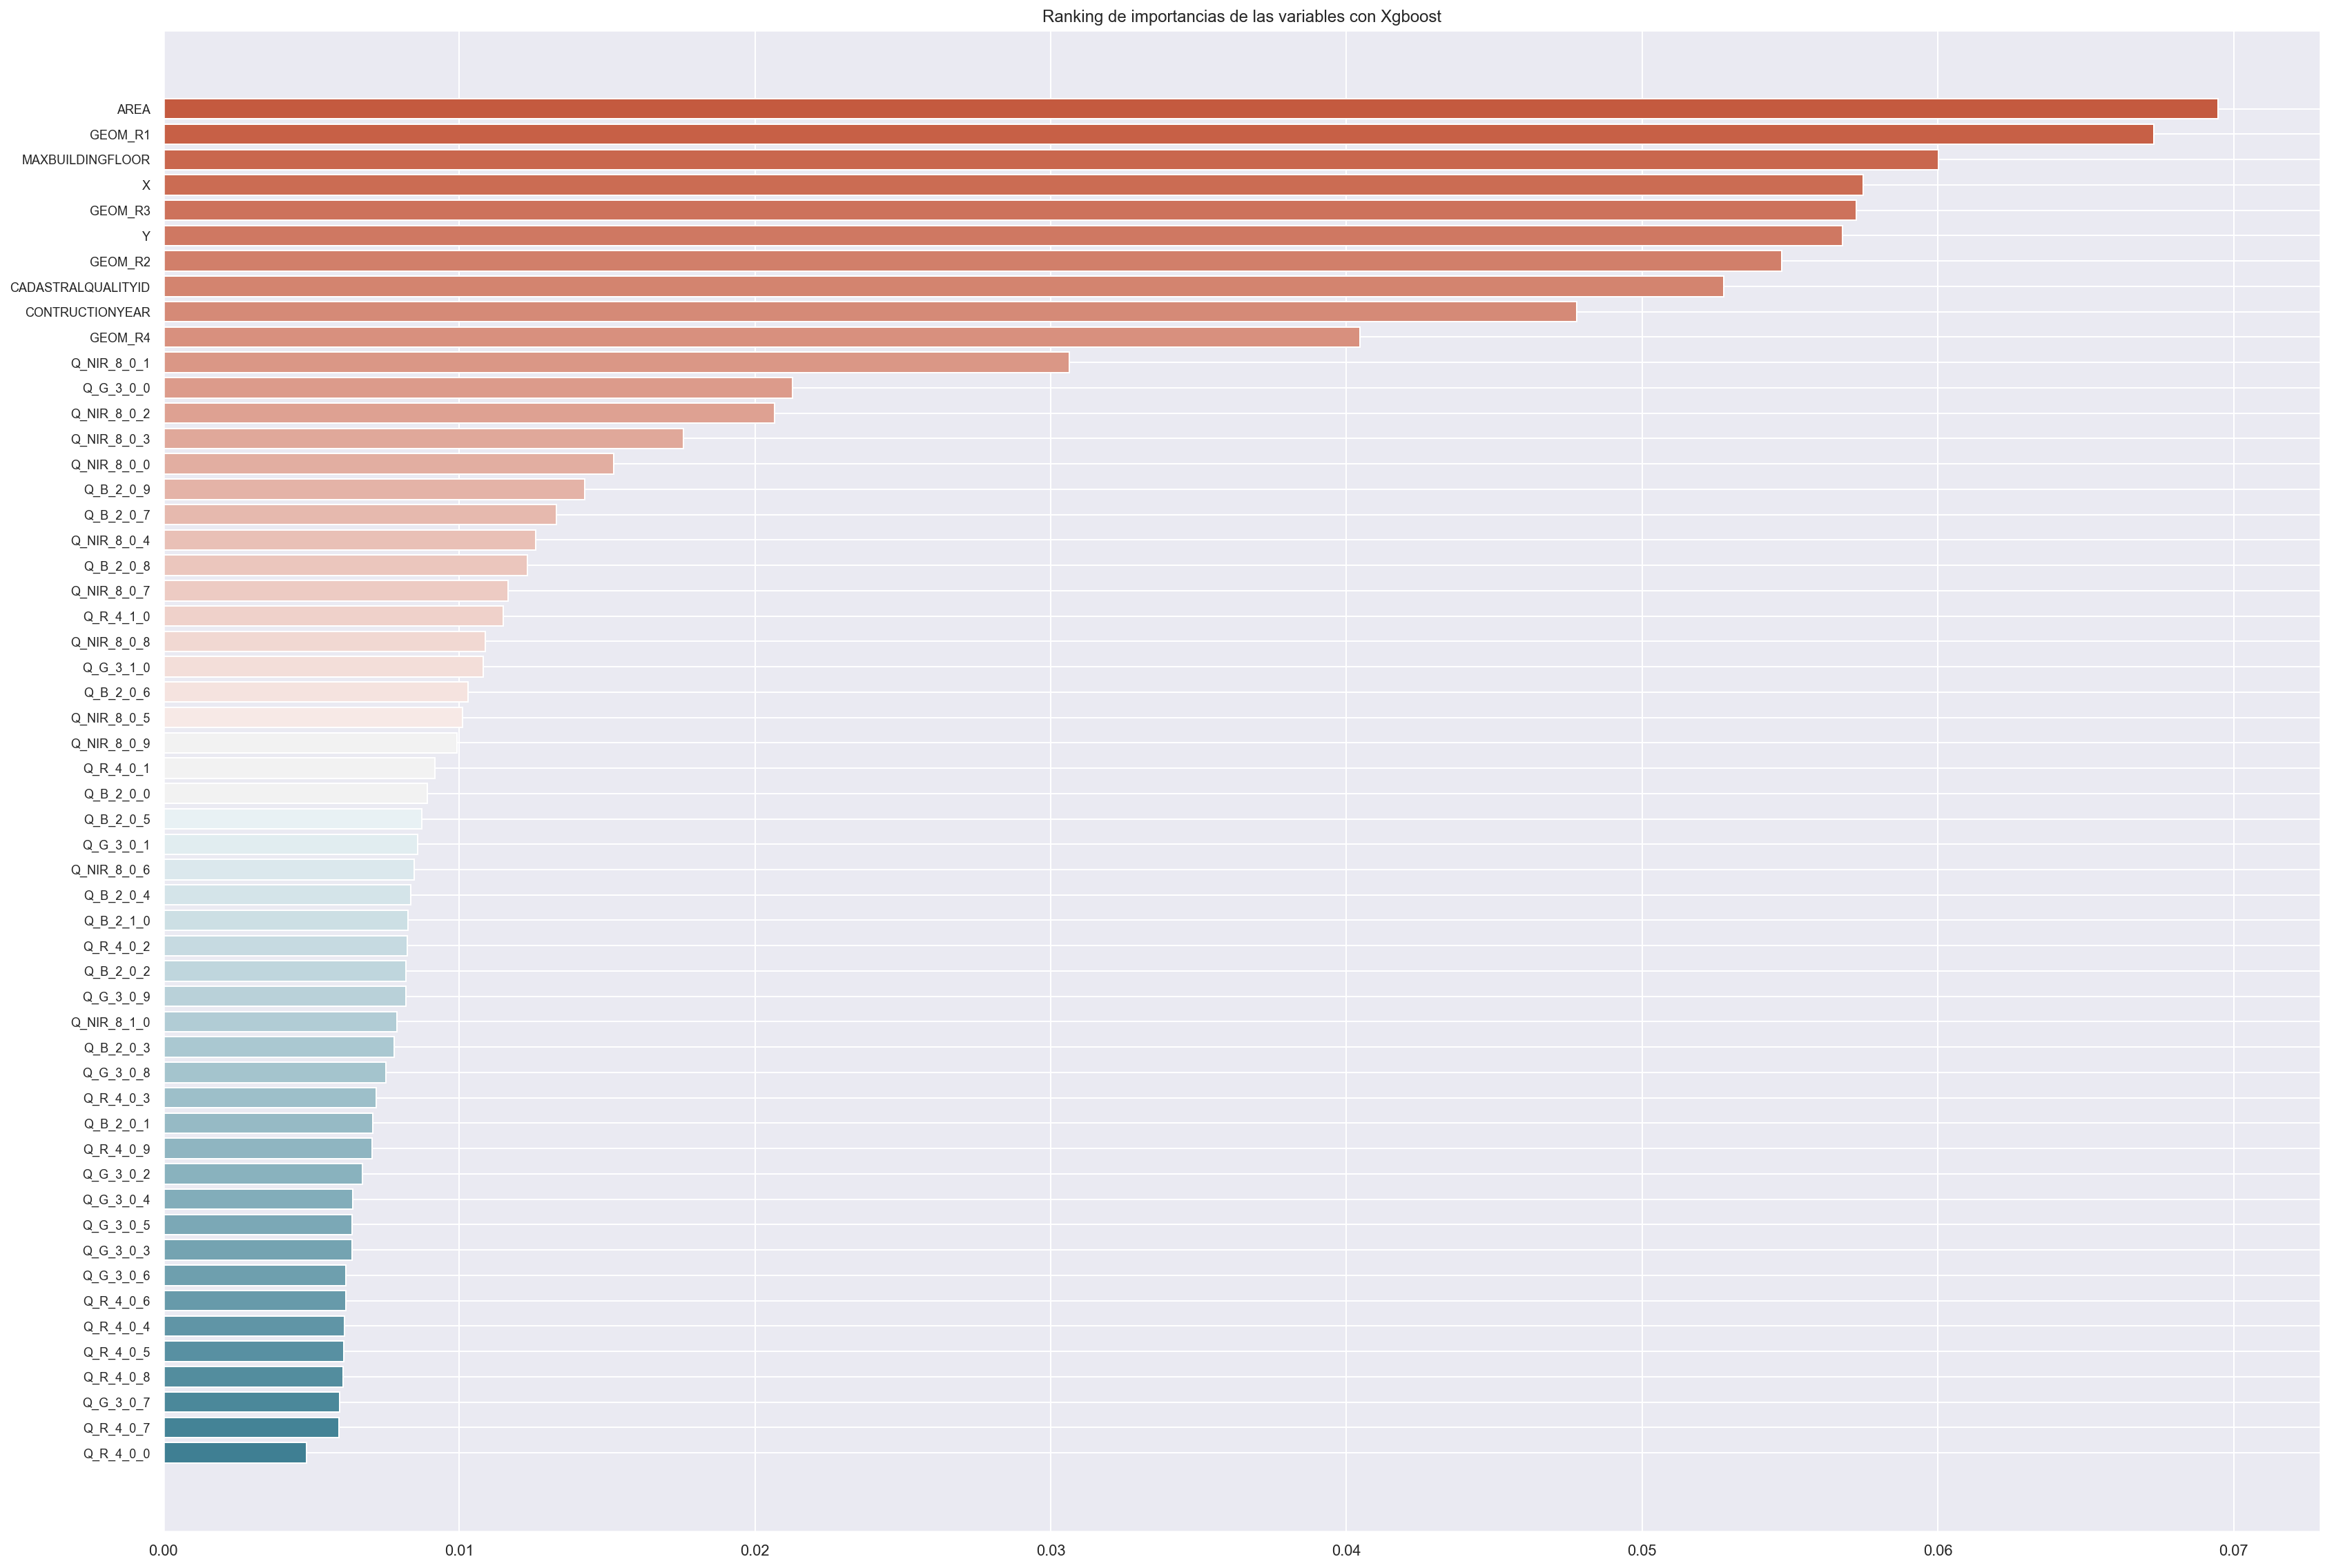

In [194]:
y_pred = pipe.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
plt.show()
print(classification_report(y_test, y_pred))
# Extrae las importancias
importances = pipe['clas'].feature_importances_
# Extrae los índices ordenados de menor a mayor
ranking = np.argsort(importances)

#Ahora que hemos obtenido las importancias de las variables y su ranking, vamos a dibujarlo
plt.figure(figsize=(28,20))
plt.title(f"Ranking de importancias de las variables con {m}")
plt.barh(range(df_modelar.shape[1]-2), importances[ranking],color=sns.diverging_palette(220, 20, n=55),align='center')
plt.yticks(range(df_modelar.shape[1]-2), X.columns[ranking], fontsize=9)
plt.show()

---